# Siamese Networks


## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "/home/shared/CS341/Dataprocessing/train"
    testing_dir = "/home/shared/CS341/Dataprocessing/finaltest/train"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

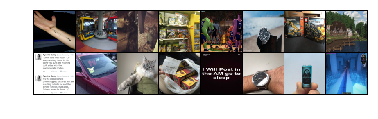

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 7))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)######？
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [11]:
import os
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
if os.path.exists('siamesecolor7_newtest.pkl'):
    checkpoint = torch.load('siamesecolor7_newtest.pkl')
    net.load_state_dict(checkpoint)

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            torch.save(net.state_dict(),'siamesecolor7_newtest.pkl')
            print('Saved model checkpoints')
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

Saved model checkpoints
Epoch number 0
 Current loss 1.503035306930542

Saved model checkpoints
Epoch number 0
 Current loss 2.9922847747802734

Saved model checkpoints
Epoch number 0
 Current loss 1.965780258178711



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 0
 Current loss 1.8462982177734375

Saved model checkpoints
Epoch number 0
 Current loss 1.3781265020370483

Saved model checkpoints
Epoch number 0
 Current loss 1.2029942274093628

Saved model checkpoints
Epoch number 0
 Current loss 1.1563316583633423



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 0
 Current loss 1.2972326278686523

Saved model checkpoints
Epoch number 0
 Current loss 1.2635340690612793

Saved model checkpoints
Epoch number 0
 Current loss 1.0384067296981812

Saved model checkpoints
Epoch number 0
 Current loss 1.4175666570663452

Saved model checkpoints
Epoch number 0
 Current loss 1.066152572631836

Saved model checkpoints
Epoch number 0
 Current loss 0.9664077162742615

Saved model checkpoints
Epoch number 0
 Current loss 1.1545355319976807

Saved model checkpoints
Epoch number 0
 Current loss 1.3147739171981812

Saved model checkpoints
Epoch number 0
 Current loss 1.1657401323318481

Saved model checkpoints
Epoch number 0
 Current loss 1.2594144344329834

Saved model checkpoints
Epoch number 0
 Current loss 1.0496339797973633

Saved model checkpoints
Epoch number 0
 Current loss 1.0324400663375854

Saved model checkpoints
Epoch number 0
 Current loss 0.9540199637413025

Saved model checkpoints
Epoch number 0
 Current loss

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 0
 Current loss 1.210671067237854

Saved model checkpoints
Epoch number 0
 Current loss 1.166488766670227

Saved model checkpoints
Epoch number 0
 Current loss 1.0562225580215454

Saved model checkpoints
Epoch number 0
 Current loss 1.2581760883331299

Saved model checkpoints
Epoch number 0
 Current loss 1.1647175550460815

Saved model checkpoints
Epoch number 0
 Current loss 1.363228440284729

Saved model checkpoints
Epoch number 0
 Current loss 0.9880073666572571

Saved model checkpoints
Epoch number 0
 Current loss 1.18650484085083

Saved model checkpoints
Epoch number 0
 Current loss 1.1247193813323975

Saved model checkpoints
Epoch number 0
 Current loss 1.0456963777542114

Saved model checkpoints
Epoch number 0
 Current loss 1.239343285560608

Saved model checkpoints
Epoch number 0
 Current loss 1.124770164489746

Saved model checkpoints
Epoch number 0
 Current loss 1.077418565750122

Saved model checkpoints
Epoch number 0
 Current loss 0.9644

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 0
 Current loss 0.9986422061920166

Saved model checkpoints
Epoch number 0
 Current loss 0.9885948896408081

Saved model checkpoints
Epoch number 0
 Current loss 1.1403230428695679

Saved model checkpoints
Epoch number 0
 Current loss 1.171412467956543

Saved model checkpoints
Epoch number 0
 Current loss 1.0788193941116333

Saved model checkpoints
Epoch number 0
 Current loss 1.1028443574905396



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 0
 Current loss 1.094271183013916

Saved model checkpoints
Epoch number 0
 Current loss 1.14072847366333

Saved model checkpoints
Epoch number 0
 Current loss 0.9618407487869263

Saved model checkpoints
Epoch number 0
 Current loss 1.1333680152893066

Saved model checkpoints
Epoch number 1
 Current loss 1.1467018127441406

Saved model checkpoints
Epoch number 1
 Current loss 1.0249935388565063

Saved model checkpoints
Epoch number 1
 Current loss 1.0398340225219727

Saved model checkpoints
Epoch number 1
 Current loss 1.084131121635437

Saved model checkpoints
Epoch number 1
 Current loss 1.0462511777877808

Saved model checkpoints
Epoch number 1
 Current loss 1.0870832204818726

Saved model checkpoints
Epoch number 1
 Current loss 1.1007062196731567

Saved model checkpoints
Epoch number 1
 Current loss 1.3120372295379639

Saved model checkpoints
Epoch number 1
 Current loss 0.9672821760177612

Saved model checkpoints
Epoch number 1
 Current loss 1.

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 1
 Current loss 1.1394087076187134

Saved model checkpoints
Epoch number 1
 Current loss 0.9465227723121643



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 1
 Current loss 1.1278839111328125

Saved model checkpoints
Epoch number 1
 Current loss 1.0587314367294312

Saved model checkpoints
Epoch number 1
 Current loss 0.9167340397834778

Saved model checkpoints
Epoch number 1
 Current loss 1.0717769861221313

Saved model checkpoints
Epoch number 1
 Current loss 1.0399487018585205

Saved model checkpoints
Epoch number 1
 Current loss 1.0807514190673828



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 1
 Current loss 0.9724517464637756

Saved model checkpoints
Epoch number 1
 Current loss 1.3551486730575562

Saved model checkpoints
Epoch number 1
 Current loss 1.0520470142364502

Saved model checkpoints
Epoch number 1
 Current loss 0.9361060261726379

Saved model checkpoints
Epoch number 1
 Current loss 1.1804094314575195

Saved model checkpoints
Epoch number 1
 Current loss 1.009387731552124

Saved model checkpoints
Epoch number 1
 Current loss 1.1261404752731323

Saved model checkpoints
Epoch number 1
 Current loss 1.0037717819213867

Saved model checkpoints
Epoch number 1
 Current loss 1.0541019439697266

Saved model checkpoints
Epoch number 1
 Current loss 1.0120760202407837

Saved model checkpoints
Epoch number 1
 Current loss 1.0159927606582642

Saved model checkpoints
Epoch number 1
 Current loss 0.9948033094406128

Saved model checkpoints
Epoch number 1
 Current loss 1.0750786066055298

Saved model checkpoints
Epoch number 1
 Current loss

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 1
 Current loss 0.9482234120368958

Saved model checkpoints
Epoch number 1
 Current loss 1.126584529876709

Saved model checkpoints
Epoch number 1
 Current loss 1.0362149477005005

Saved model checkpoints
Epoch number 1
 Current loss 1.2394752502441406

Saved model checkpoints
Epoch number 1
 Current loss 1.0529544353485107

Saved model checkpoints
Epoch number 1
 Current loss 0.9821694493293762

Saved model checkpoints
Epoch number 1
 Current loss 1.0343533754348755

Saved model checkpoints
Epoch number 1
 Current loss 0.9728610515594482

Saved model checkpoints
Epoch number 1
 Current loss 0.8891317248344421

Saved model checkpoints
Epoch number 1
 Current loss 0.9915961027145386

Saved model checkpoints
Epoch number 1
 Current loss 0.9772029519081116



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 2
 Current loss 1.1740516424179077

Saved model checkpoints
Epoch number 2
 Current loss 0.9836947917938232

Saved model checkpoints
Epoch number 2
 Current loss 1.0410434007644653

Saved model checkpoints
Epoch number 2
 Current loss 1.1659384965896606

Saved model checkpoints
Epoch number 2
 Current loss 1.0969358682632446

Saved model checkpoints
Epoch number 2
 Current loss 1.067790150642395

Saved model checkpoints
Epoch number 2
 Current loss 1.0807480812072754

Saved model checkpoints
Epoch number 2
 Current loss 0.9799481630325317

Saved model checkpoints
Epoch number 2
 Current loss 1.0431100130081177

Saved model checkpoints
Epoch number 2
 Current loss 1.0448663234710693

Saved model checkpoints
Epoch number 2
 Current loss 1.0799739360809326



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 2
 Current loss 1.04524564743042

Saved model checkpoints
Epoch number 2
 Current loss 1.0493903160095215

Saved model checkpoints
Epoch number 2
 Current loss 1.0262359380722046

Saved model checkpoints
Epoch number 2
 Current loss 0.9870496988296509

Saved model checkpoints
Epoch number 2
 Current loss 1.0299780368804932

Saved model checkpoints
Epoch number 2
 Current loss 1.1186374425888062

Saved model checkpoints
Epoch number 2
 Current loss 1.0801101922988892

Saved model checkpoints
Epoch number 2
 Current loss 0.9860303997993469

Saved model checkpoints
Epoch number 2
 Current loss 0.9566519260406494

Saved model checkpoints
Epoch number 2
 Current loss 1.1021735668182373

Saved model checkpoints
Epoch number 2
 Current loss 1.1285098791122437

Saved model checkpoints
Epoch number 2
 Current loss 1.063801884651184

Saved model checkpoints
Epoch number 2
 Current loss 1.1931500434875488

Saved model checkpoints
Epoch number 2
 Current loss 1

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 2
 Current loss 1.1473649740219116



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 2
 Current loss 1.0211271047592163

Saved model checkpoints
Epoch number 2
 Current loss 0.9747771620750427

Saved model checkpoints
Epoch number 2
 Current loss 1.0609688758850098

Saved model checkpoints
Epoch number 2
 Current loss 1.0330818891525269

Saved model checkpoints
Epoch number 2
 Current loss 1.051709532737732

Saved model checkpoints
Epoch number 2
 Current loss 1.1432609558105469



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 2
 Current loss 0.9825804233551025

Saved model checkpoints
Epoch number 2
 Current loss 1.1072142124176025



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 2
 Current loss 1.0254772901535034

Saved model checkpoints
Epoch number 2
 Current loss 1.245922565460205

Saved model checkpoints
Epoch number 2
 Current loss 1.1417888402938843

Saved model checkpoints
Epoch number 2
 Current loss 0.8530081510543823

Saved model checkpoints
Epoch number 2
 Current loss 1.1495492458343506

Saved model checkpoints
Epoch number 2
 Current loss 1.0511292219161987

Saved model checkpoints
Epoch number 2
 Current loss 1.0107481479644775

Saved model checkpoints
Epoch number 2
 Current loss 1.0627985000610352

Saved model checkpoints
Epoch number 2
 Current loss 1.0000457763671875

Saved model checkpoints
Epoch number 2
 Current loss 1.1456259489059448

Saved model checkpoints
Epoch number 2
 Current loss 0.9280304908752441



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 3
 Current loss 1.0185099840164185

Saved model checkpoints
Epoch number 3
 Current loss 1.015647292137146

Saved model checkpoints
Epoch number 3
 Current loss 0.956139087677002

Saved model checkpoints
Epoch number 3
 Current loss 1.0531879663467407

Saved model checkpoints
Epoch number 3
 Current loss 1.2293683290481567

Saved model checkpoints
Epoch number 3
 Current loss 0.9551539421081543

Saved model checkpoints
Epoch number 3
 Current loss 1.0152593851089478

Saved model checkpoints
Epoch number 3
 Current loss 0.9912407398223877

Saved model checkpoints
Epoch number 3
 Current loss 0.964706301689148



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 3
 Current loss 0.875196099281311

Saved model checkpoints
Epoch number 3
 Current loss 1.025956153869629

Saved model checkpoints
Epoch number 3
 Current loss 1.1557278633117676

Saved model checkpoints
Epoch number 3
 Current loss 1.1053800582885742

Saved model checkpoints
Epoch number 3
 Current loss 0.9850103259086609

Saved model checkpoints
Epoch number 3
 Current loss 0.9999062418937683

Saved model checkpoints
Epoch number 3
 Current loss 1.009835958480835



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 3
 Current loss 1.048288106918335

Saved model checkpoints
Epoch number 3
 Current loss 1.0791834592819214

Saved model checkpoints
Epoch number 3
 Current loss 0.9246563911437988

Saved model checkpoints
Epoch number 3
 Current loss 1.010880947113037

Saved model checkpoints
Epoch number 3
 Current loss 1.1393241882324219

Saved model checkpoints
Epoch number 3
 Current loss 1.106981635093689

Saved model checkpoints
Epoch number 3
 Current loss 1.0034511089324951

Saved model checkpoints
Epoch number 3
 Current loss 1.1474647521972656

Saved model checkpoints
Epoch number 3
 Current loss 0.9482431411743164

Saved model checkpoints
Epoch number 3
 Current loss 1.0185580253601074

Saved model checkpoints
Epoch number 3
 Current loss 0.9303250312805176



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 3
 Current loss 0.9856268763542175

Saved model checkpoints
Epoch number 3
 Current loss 1.153956651687622

Saved model checkpoints
Epoch number 3
 Current loss 1.0591742992401123

Saved model checkpoints
Epoch number 3
 Current loss 0.9901155829429626

Saved model checkpoints
Epoch number 3
 Current loss 1.053991436958313

Saved model checkpoints
Epoch number 3
 Current loss 1.035656213760376

Saved model checkpoints
Epoch number 3
 Current loss 1.0433287620544434

Saved model checkpoints
Epoch number 3
 Current loss 0.9895866513252258

Saved model checkpoints
Epoch number 3
 Current loss 0.9347217679023743

Saved model checkpoints
Epoch number 3
 Current loss 0.9167212247848511

Saved model checkpoints
Epoch number 3
 Current loss 0.9251337647438049

Saved model checkpoints
Epoch number 3
 Current loss 0.9414109587669373

Saved model checkpoints
Epoch number 3
 Current loss 1.0492494106292725

Saved model checkpoints
Epoch number 3
 Current loss 1

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 4
 Current loss 1.0729321241378784

Saved model checkpoints
Epoch number 4
 Current loss 0.8585052490234375

Saved model checkpoints
Epoch number 4
 Current loss 1.1041287183761597



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 4
 Current loss 0.9665594100952148

Saved model checkpoints
Epoch number 4
 Current loss 0.9998515248298645

Saved model checkpoints
Epoch number 4
 Current loss 1.189749836921692

Saved model checkpoints
Epoch number 4
 Current loss 1.0385571718215942

Saved model checkpoints
Epoch number 4
 Current loss 1.0428344011306763

Saved model checkpoints
Epoch number 4
 Current loss 0.9064395427703857

Saved model checkpoints
Epoch number 4
 Current loss 0.9814136624336243

Saved model checkpoints
Epoch number 4
 Current loss 0.976703941822052

Saved model checkpoints
Epoch number 4
 Current loss 1.0689393281936646

Saved model checkpoints
Epoch number 4
 Current loss 0.9701841473579407



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 4
 Current loss 0.9829004406929016

Saved model checkpoints
Epoch number 4
 Current loss 1.0573558807373047

Saved model checkpoints
Epoch number 4
 Current loss 0.9626104831695557

Saved model checkpoints
Epoch number 4
 Current loss 0.9818416833877563

Saved model checkpoints
Epoch number 4
 Current loss 1.0025484561920166

Saved model checkpoints
Epoch number 4
 Current loss 0.9419079422950745

Saved model checkpoints
Epoch number 4
 Current loss 0.9005473256111145

Saved model checkpoints
Epoch number 4
 Current loss 0.9196639657020569

Saved model checkpoints
Epoch number 4
 Current loss 1.0059341192245483

Saved model checkpoints
Epoch number 4
 Current loss 0.9982748627662659

Saved model checkpoints
Epoch number 4
 Current loss 1.0357686281204224

Saved model checkpoints
Epoch number 4
 Current loss 1.0322389602661133

Saved model checkpoints
Epoch number 4
 Current loss 1.0069941282272339

Saved model checkpoints
Epoch number 4
 Current los

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 4
 Current loss 0.9976087808609009

Saved model checkpoints
Epoch number 4
 Current loss 0.8796650767326355

Saved model checkpoints
Epoch number 4
 Current loss 0.9880076050758362



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 4
 Current loss 1.1381523609161377

Saved model checkpoints
Epoch number 4
 Current loss 0.9261398315429688

Saved model checkpoints
Epoch number 4
 Current loss 1.0226447582244873

Saved model checkpoints
Epoch number 4
 Current loss 0.8818585872650146

Saved model checkpoints
Epoch number 4
 Current loss 0.9791679382324219

Saved model checkpoints
Epoch number 4
 Current loss 0.9277390837669373

Saved model checkpoints
Epoch number 4
 Current loss 1.023632287979126

Saved model checkpoints
Epoch number 4
 Current loss 1.0196183919906616

Saved model checkpoints
Epoch number 4
 Current loss 0.8822774291038513

Saved model checkpoints
Epoch number 4
 Current loss 0.9902857542037964

Saved model checkpoints
Epoch number 4
 Current loss 1.0141769647598267

Saved model checkpoints
Epoch number 4
 Current loss 0.9632951021194458

Saved model checkpoints
Epoch number 4
 Current loss 1.0720281600952148

Saved model checkpoints
Epoch number 4
 Current loss

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 4
 Current loss 1.0761101245880127



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 4
 Current loss 0.9713425040245056

Saved model checkpoints
Epoch number 4
 Current loss 0.9746743440628052

Saved model checkpoints
Epoch number 5
 Current loss 0.9205970168113708

Saved model checkpoints
Epoch number 5
 Current loss 1.0103421211242676

Saved model checkpoints
Epoch number 5
 Current loss 0.9715102314949036

Saved model checkpoints
Epoch number 5
 Current loss 0.8970792889595032

Saved model checkpoints
Epoch number 5
 Current loss 0.968996524810791

Saved model checkpoints
Epoch number 5
 Current loss 0.9819167256355286

Saved model checkpoints
Epoch number 5
 Current loss 1.0385922193527222

Saved model checkpoints
Epoch number 5
 Current loss 0.9482169151306152

Saved model checkpoints
Epoch number 5
 Current loss 1.0159755945205688

Saved model checkpoints
Epoch number 5
 Current loss 0.9217302799224854

Saved model checkpoints
Epoch number 5
 Current loss 0.9517276883125305

Saved model checkpoints
Epoch number 5
 Current loss

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 5
 Current loss 0.8687020540237427

Saved model checkpoints
Epoch number 5
 Current loss 0.9382947683334351

Saved model checkpoints
Epoch number 5
 Current loss 1.0085632801055908

Saved model checkpoints
Epoch number 5
 Current loss 0.9801150560379028

Saved model checkpoints
Epoch number 5
 Current loss 0.8330143094062805

Saved model checkpoints
Epoch number 5
 Current loss 0.9326909780502319

Saved model checkpoints
Epoch number 5
 Current loss 0.9722830653190613

Saved model checkpoints
Epoch number 5
 Current loss 0.942674458026886

Saved model checkpoints
Epoch number 5
 Current loss 0.9355547428131104

Saved model checkpoints
Epoch number 5
 Current loss 0.909788966178894

Saved model checkpoints
Epoch number 5
 Current loss 1.0282268524169922

Saved model checkpoints
Epoch number 5
 Current loss 1.055482268333435

Saved model checkpoints
Epoch number 5
 Current loss 0.9671048521995544

Saved model checkpoints
Epoch number 5
 Current loss 0

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 5
 Current loss 1.0791606903076172

Saved model checkpoints
Epoch number 5
 Current loss 0.9506179690361023

Saved model checkpoints
Epoch number 5
 Current loss 0.8757829070091248



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 5
 Current loss 0.7947607636451721

Saved model checkpoints
Epoch number 5
 Current loss 1.0567779541015625

Saved model checkpoints
Epoch number 5
 Current loss 0.9832634925842285

Saved model checkpoints
Epoch number 5
 Current loss 0.9773353934288025

Saved model checkpoints
Epoch number 5
 Current loss 0.9681277275085449



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 5
 Current loss 1.0664331912994385



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 5
 Current loss 0.9272658228874207

Saved model checkpoints
Epoch number 5
 Current loss 0.938973069190979



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 5
 Current loss 0.9542953968048096

Saved model checkpoints
Epoch number 5
 Current loss 1.0130367279052734

Saved model checkpoints
Epoch number 5
 Current loss 0.7733179330825806

Saved model checkpoints
Epoch number 6
 Current loss 0.9387688040733337



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 6
 Current loss 0.8973509073257446

Saved model checkpoints
Epoch number 6
 Current loss 0.9406454563140869

Saved model checkpoints
Epoch number 6
 Current loss 0.8933662176132202

Saved model checkpoints
Epoch number 6
 Current loss 0.9263203740119934

Saved model checkpoints
Epoch number 6
 Current loss 0.8021298050880432



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 6
 Current loss 1.0304466485977173

Saved model checkpoints
Epoch number 6
 Current loss 0.9815754294395447

Saved model checkpoints
Epoch number 6
 Current loss 1.0487719774246216

Saved model checkpoints
Epoch number 6
 Current loss 1.0159885883331299

Saved model checkpoints
Epoch number 6
 Current loss 0.9706785082817078

Saved model checkpoints
Epoch number 6
 Current loss 0.9911983013153076

Saved model checkpoints
Epoch number 6
 Current loss 1.0143157243728638



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 6
 Current loss 0.987854540348053

Saved model checkpoints
Epoch number 6
 Current loss 0.924169659614563



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 6
 Current loss 0.9127351641654968

Saved model checkpoints
Epoch number 6
 Current loss 0.9405867457389832

Saved model checkpoints
Epoch number 6
 Current loss 0.958227276802063

Saved model checkpoints
Epoch number 6
 Current loss 0.7981739044189453



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 6
 Current loss 0.9274135828018188

Saved model checkpoints
Epoch number 6
 Current loss 0.9238897562026978

Saved model checkpoints
Epoch number 6
 Current loss 0.9143949747085571

Saved model checkpoints
Epoch number 6
 Current loss 0.8577631115913391

Saved model checkpoints
Epoch number 6
 Current loss 0.83662348985672



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 6
 Current loss 1.0495514869689941

Saved model checkpoints
Epoch number 6
 Current loss 0.9984297156333923

Saved model checkpoints
Epoch number 6
 Current loss 0.9013416767120361

Saved model checkpoints
Epoch number 6
 Current loss 0.9075775742530823

Saved model checkpoints
Epoch number 6
 Current loss 0.9172742366790771

Saved model checkpoints
Epoch number 6
 Current loss 0.8183274865150452

Saved model checkpoints
Epoch number 6
 Current loss 0.9571823477745056

Saved model checkpoints
Epoch number 6
 Current loss 1.1001038551330566

Saved model checkpoints
Epoch number 6
 Current loss 1.112288236618042

Saved model checkpoints
Epoch number 6
 Current loss 0.8564453125

Saved model checkpoints
Epoch number 6
 Current loss 0.9072936773300171

Saved model checkpoints
Epoch number 6
 Current loss 1.037846565246582

Saved model checkpoints
Epoch number 6
 Current loss 0.9254022240638733

Saved model checkpoints
Epoch number 6
 Current loss 0.9327

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 6
 Current loss 0.8102832436561584

Saved model checkpoints
Epoch number 6
 Current loss 0.9906927347183228

Saved model checkpoints
Epoch number 6
 Current loss 1.0278466939926147



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 7
 Current loss 0.8899859189987183

Saved model checkpoints
Epoch number 7
 Current loss 0.9363910555839539

Saved model checkpoints
Epoch number 7
 Current loss 0.898470401763916



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 7
 Current loss 0.9771133065223694

Saved model checkpoints
Epoch number 7
 Current loss 0.8202782273292542

Saved model checkpoints
Epoch number 7
 Current loss 1.106719732284546



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 7
 Current loss 1.0397011041641235

Saved model checkpoints
Epoch number 7
 Current loss 0.7817321419715881

Saved model checkpoints
Epoch number 7
 Current loss 0.9144264459609985

Saved model checkpoints
Epoch number 7
 Current loss 0.873835563659668

Saved model checkpoints
Epoch number 7
 Current loss 0.9612382650375366



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 7
 Current loss 0.953822135925293

Saved model checkpoints
Epoch number 7
 Current loss 1.0014780759811401

Saved model checkpoints
Epoch number 7
 Current loss 0.872723400592804



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 7
 Current loss 0.8581827282905579

Saved model checkpoints
Epoch number 7
 Current loss 0.8602838516235352

Saved model checkpoints
Epoch number 7
 Current loss 0.9955294728279114

Saved model checkpoints
Epoch number 7
 Current loss 0.9271962642669678

Saved model checkpoints
Epoch number 7
 Current loss 0.9224866032600403

Saved model checkpoints
Epoch number 7
 Current loss 0.9115159511566162

Saved model checkpoints
Epoch number 7
 Current loss 1.1190638542175293

Saved model checkpoints
Epoch number 7
 Current loss 0.9695852398872375

Saved model checkpoints
Epoch number 7
 Current loss 0.8903391361236572

Saved model checkpoints
Epoch number 7
 Current loss 0.9450467824935913



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 7
 Current loss 0.9497659802436829

Saved model checkpoints
Epoch number 7
 Current loss 0.9226621389389038

Saved model checkpoints
Epoch number 7
 Current loss 1.0193467140197754

Saved model checkpoints
Epoch number 7
 Current loss 0.9792743921279907



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 7
 Current loss 0.85612952709198



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 7
 Current loss 0.8708521127700806

Saved model checkpoints
Epoch number 7
 Current loss 0.7367231845855713

Saved model checkpoints
Epoch number 7
 Current loss 0.9434877038002014

Saved model checkpoints
Epoch number 7
 Current loss 0.8624281883239746

Saved model checkpoints
Epoch number 7
 Current loss 0.9276186227798462

Saved model checkpoints
Epoch number 7
 Current loss 0.8049010634422302

Saved model checkpoints
Epoch number 7
 Current loss 0.9698753356933594

Saved model checkpoints
Epoch number 7
 Current loss 0.8593891263008118

Saved model checkpoints
Epoch number 7
 Current loss 0.8586850166320801

Saved model checkpoints
Epoch number 7
 Current loss 0.7933709621429443

Saved model checkpoints
Epoch number 7
 Current loss 0.8490432500839233

Saved model checkpoints
Epoch number 7
 Current loss 1.0552819967269897

Saved model checkpoints
Epoch number 7
 Current loss 0.9265438318252563

Saved model checkpoints
Epoch number 7
 Current los

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 8
 Current loss 0.8023382425308228

Saved model checkpoints
Epoch number 8
 Current loss 0.8025122880935669

Saved model checkpoints
Epoch number 8
 Current loss 0.9303995966911316

Saved model checkpoints
Epoch number 8
 Current loss 0.8828123211860657

Saved model checkpoints
Epoch number 8
 Current loss 0.8659953474998474

Saved model checkpoints
Epoch number 8
 Current loss 0.8224742412567139

Saved model checkpoints
Epoch number 8
 Current loss 0.942106306552887

Saved model checkpoints
Epoch number 8
 Current loss 0.8935881853103638

Saved model checkpoints
Epoch number 8
 Current loss 0.7702109217643738

Saved model checkpoints
Epoch number 8
 Current loss 0.9520471692085266

Saved model checkpoints
Epoch number 8
 Current loss 0.886121928691864

Saved model checkpoints
Epoch number 8
 Current loss 0.9940069913864136

Saved model checkpoints
Epoch number 8
 Current loss 0.77503502368927

Saved model checkpoints
Epoch number 8
 Current loss 0.

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 8
 Current loss 0.7602879405021667

Saved model checkpoints
Epoch number 8
 Current loss 0.756909966468811

Saved model checkpoints
Epoch number 8
 Current loss 0.8780389428138733

Saved model checkpoints
Epoch number 8
 Current loss 0.815741240978241

Saved model checkpoints
Epoch number 8
 Current loss 0.9830501079559326

Saved model checkpoints
Epoch number 8
 Current loss 1.0937985181808472



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 8
 Current loss 1.1899183988571167

Saved model checkpoints
Epoch number 8
 Current loss 0.8435393571853638

Saved model checkpoints
Epoch number 8
 Current loss 1.0325794219970703

Saved model checkpoints
Epoch number 8
 Current loss 0.956882655620575



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 8
 Current loss 0.7763171195983887

Saved model checkpoints
Epoch number 8
 Current loss 0.9395753741264343

Saved model checkpoints
Epoch number 8
 Current loss 0.7772193551063538

Saved model checkpoints
Epoch number 8
 Current loss 0.8431013822555542

Saved model checkpoints
Epoch number 8
 Current loss 0.8027888536453247

Saved model checkpoints
Epoch number 8
 Current loss 0.8484588861465454

Saved model checkpoints
Epoch number 8
 Current loss 0.97329181432724

Saved model checkpoints
Epoch number 8
 Current loss 0.8262683153152466

Saved model checkpoints
Epoch number 8
 Current loss 0.8763949275016785

Saved model checkpoints
Epoch number 8
 Current loss 0.9658023715019226

Saved model checkpoints
Epoch number 8
 Current loss 0.9689399003982544

Saved model checkpoints
Epoch number 8
 Current loss 0.7971159219741821

Saved model checkpoints
Epoch number 8
 Current loss 0.8990699648857117

Saved model checkpoints
Epoch number 8
 Current loss 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 8
 Current loss 0.8545256853103638

Saved model checkpoints
Epoch number 9
 Current loss 0.8439309597015381

Saved model checkpoints
Epoch number 9
 Current loss 0.8898398876190186

Saved model checkpoints
Epoch number 9
 Current loss 0.8460683226585388

Saved model checkpoints
Epoch number 9
 Current loss 0.8129781484603882

Saved model checkpoints
Epoch number 9
 Current loss 1.0785810947418213

Saved model checkpoints
Epoch number 9
 Current loss 0.9222462773323059

Saved model checkpoints
Epoch number 9
 Current loss 0.9165891408920288

Saved model checkpoints
Epoch number 9
 Current loss 0.7163943648338318

Saved model checkpoints
Epoch number 9
 Current loss 0.8371432423591614

Saved model checkpoints
Epoch number 9
 Current loss 0.8758037090301514

Saved model checkpoints
Epoch number 9
 Current loss 0.8883249163627625

Saved model checkpoints
Epoch number 9
 Current loss 0.8144253492355347

Saved model checkpoints
Epoch number 9
 Current los

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 10
 Current loss 0.8931096196174622

Saved model checkpoints
Epoch number 10
 Current loss 0.9643697738647461

Saved model checkpoints
Epoch number 10
 Current loss 0.8602422475814819

Saved model checkpoints
Epoch number 10
 Current loss 0.7853133082389832

Saved model checkpoints
Epoch number 10
 Current loss 0.6959086060523987

Saved model checkpoints
Epoch number 10
 Current loss 0.7933350205421448

Saved model checkpoints
Epoch number 10
 Current loss 0.8809913396835327

Saved model checkpoints
Epoch number 10
 Current loss 0.9759128093719482

Saved model checkpoints
Epoch number 10
 Current loss 0.7266884446144104

Saved model checkpoints
Epoch number 10
 Current loss 0.9168456792831421

Saved model checkpoints
Epoch number 10
 Current loss 0.9165513515472412

Saved model checkpoints
Epoch number 10
 Current loss 0.7912264466285706

Saved model checkpoints
Epoch number 10
 Current loss 0.9008290767669678

Saved model checkpoints
Epoch number 1

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 10
 Current loss 0.7973957657814026

Saved model checkpoints
Epoch number 10
 Current loss 0.5344200730323792

Saved model checkpoints
Epoch number 10
 Current loss 0.7206760048866272

Saved model checkpoints
Epoch number 10
 Current loss 0.7620497941970825

Saved model checkpoints
Epoch number 10
 Current loss 0.6961450576782227

Saved model checkpoints
Epoch number 10
 Current loss 0.744144082069397

Saved model checkpoints
Epoch number 10
 Current loss 0.7552727460861206



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 10
 Current loss 0.9317649602890015

Saved model checkpoints
Epoch number 10
 Current loss 0.8963397145271301

Saved model checkpoints
Epoch number 10
 Current loss 0.7191473841667175

Saved model checkpoints
Epoch number 10
 Current loss 0.858714759349823

Saved model checkpoints
Epoch number 10
 Current loss 0.7757578492164612

Saved model checkpoints
Epoch number 10
 Current loss 0.8524832725524902

Saved model checkpoints
Epoch number 10
 Current loss 0.7222699522972107

Saved model checkpoints
Epoch number 10
 Current loss 0.7449089884757996

Saved model checkpoints
Epoch number 10
 Current loss 0.5792295932769775

Saved model checkpoints
Epoch number 10
 Current loss 0.7725558876991272



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 11
 Current loss 0.8967615365982056

Saved model checkpoints
Epoch number 11
 Current loss 0.9130085110664368

Saved model checkpoints
Epoch number 11
 Current loss 0.7448732852935791

Saved model checkpoints
Epoch number 11
 Current loss 0.7587124109268188

Saved model checkpoints
Epoch number 11
 Current loss 0.6317809224128723

Saved model checkpoints
Epoch number 11
 Current loss 0.6529734134674072

Saved model checkpoints
Epoch number 11
 Current loss 0.6286329627037048



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 11
 Current loss 0.7779416441917419

Saved model checkpoints
Epoch number 11
 Current loss 0.9315425753593445

Saved model checkpoints
Epoch number 11
 Current loss 0.7507020831108093

Saved model checkpoints
Epoch number 11
 Current loss 0.6356385350227356

Saved model checkpoints
Epoch number 11
 Current loss 0.8604615926742554

Saved model checkpoints
Epoch number 11
 Current loss 0.7071981430053711

Saved model checkpoints
Epoch number 11
 Current loss 0.5793105363845825

Saved model checkpoints
Epoch number 11
 Current loss 0.7452990412712097

Saved model checkpoints
Epoch number 11
 Current loss 0.6703697443008423

Saved model checkpoints
Epoch number 11
 Current loss 0.6792045831680298

Saved model checkpoints
Epoch number 11
 Current loss 0.7575569152832031

Saved model checkpoints
Epoch number 11
 Current loss 0.8100276589393616

Saved model checkpoints
Epoch number 11
 Current loss 0.620137631893158

Saved model checkpoints
Epoch number 11

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 11
 Current loss 0.6779910922050476

Saved model checkpoints
Epoch number 11
 Current loss 0.8154788613319397

Saved model checkpoints
Epoch number 11
 Current loss 0.6891613602638245

Saved model checkpoints
Epoch number 11
 Current loss 0.6713992357254028

Saved model checkpoints
Epoch number 11
 Current loss 0.6411305069923401



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 11
 Current loss 0.6954424977302551

Saved model checkpoints
Epoch number 11
 Current loss 0.6777051091194153

Saved model checkpoints
Epoch number 12
 Current loss 0.7776614427566528

Saved model checkpoints
Epoch number 12
 Current loss 0.8958792686462402

Saved model checkpoints
Epoch number 12
 Current loss 0.6760833263397217

Saved model checkpoints
Epoch number 12
 Current loss 0.7364510893821716

Saved model checkpoints
Epoch number 12
 Current loss 0.7656812071800232

Saved model checkpoints
Epoch number 12
 Current loss 0.6920580863952637

Saved model checkpoints
Epoch number 12
 Current loss 0.6473895907402039

Saved model checkpoints
Epoch number 12
 Current loss 0.7454088926315308

Saved model checkpoints
Epoch number 12
 Current loss 0.7943008542060852

Saved model checkpoints
Epoch number 12
 Current loss 0.8006576299667358

Saved model checkpoints
Epoch number 12
 Current loss 0.8167324066162109

Saved model checkpoints
Epoch number 1

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 12
 Current loss 0.8109707832336426

Saved model checkpoints
Epoch number 12
 Current loss 0.7713000178337097

Saved model checkpoints
Epoch number 12
 Current loss 0.624366044998169



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 12
 Current loss 0.5644550323486328

Saved model checkpoints
Epoch number 12
 Current loss 0.7783007621765137

Saved model checkpoints
Epoch number 12
 Current loss 0.5338413715362549



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 12
 Current loss 0.882509708404541

Saved model checkpoints
Epoch number 12
 Current loss 0.5738809108734131

Saved model checkpoints
Epoch number 12
 Current loss 0.790619969367981

Saved model checkpoints
Epoch number 12
 Current loss 0.7021650075912476



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 12
 Current loss 0.7557541728019714

Saved model checkpoints
Epoch number 12
 Current loss 0.6000295877456665

Saved model checkpoints
Epoch number 12
 Current loss 0.5329135060310364

Saved model checkpoints
Epoch number 12
 Current loss 0.5631529092788696

Saved model checkpoints
Epoch number 12
 Current loss 0.6109118461608887

Saved model checkpoints
Epoch number 12
 Current loss 0.5235133767127991

Saved model checkpoints
Epoch number 12
 Current loss 0.673945426940918

Saved model checkpoints
Epoch number 12
 Current loss 0.6108065247535706

Saved model checkpoints
Epoch number 12
 Current loss 0.7180885076522827

Saved model checkpoints
Epoch number 12
 Current loss 0.6123000383377075

Saved model checkpoints
Epoch number 12
 Current loss 0.4726995527744293

Saved model checkpoints
Epoch number 12
 Current loss 0.5831981897354126

Saved model checkpoints
Epoch number 12
 Current loss 0.6764482855796814

Saved model checkpoints
Epoch number 12

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 12
 Current loss 0.6630247235298157

Saved model checkpoints
Epoch number 12
 Current loss 0.666456937789917

Saved model checkpoints
Epoch number 13
 Current loss 0.7411924004554749

Saved model checkpoints
Epoch number 13
 Current loss 0.7967824339866638

Saved model checkpoints
Epoch number 13
 Current loss 0.7140668630599976

Saved model checkpoints
Epoch number 13
 Current loss 0.514307975769043

Saved model checkpoints
Epoch number 13
 Current loss 0.5962637066841125

Saved model checkpoints
Epoch number 13
 Current loss 0.639962911605835

Saved model checkpoints
Epoch number 13
 Current loss 0.6808354258537292

Saved model checkpoints
Epoch number 13
 Current loss 0.6488677263259888

Saved model checkpoints
Epoch number 13
 Current loss 0.693315863609314

Saved model checkpoints
Epoch number 13
 Current loss 0.5847288966178894

Saved model checkpoints
Epoch number 13
 Current loss 0.660956621170044

Saved model checkpoints
Epoch number 13
 Cu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 13
 Current loss 0.7728126049041748

Saved model checkpoints
Epoch number 13
 Current loss 0.5099530220031738

Saved model checkpoints
Epoch number 13
 Current loss 0.6154555082321167

Saved model checkpoints
Epoch number 13
 Current loss 0.6206905841827393

Saved model checkpoints
Epoch number 13
 Current loss 0.5385395884513855

Saved model checkpoints
Epoch number 13
 Current loss 0.7242628931999207

Saved model checkpoints
Epoch number 13
 Current loss 0.6046180129051208

Saved model checkpoints
Epoch number 13
 Current loss 0.5434069633483887

Saved model checkpoints
Epoch number 13
 Current loss 0.5764834880828857

Saved model checkpoints
Epoch number 13
 Current loss 0.5509330630302429

Saved model checkpoints
Epoch number 13
 Current loss 0.6654276847839355

Saved model checkpoints
Epoch number 13
 Current loss 0.7398545742034912



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 13
 Current loss 0.7643843293190002



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 13
 Current loss 0.683455765247345

Saved model checkpoints
Epoch number 13
 Current loss 0.5906139612197876

Saved model checkpoints
Epoch number 13
 Current loss 0.683001697063446

Saved model checkpoints
Epoch number 13
 Current loss 0.5172059535980225

Saved model checkpoints
Epoch number 13
 Current loss 0.5911939740180969

Saved model checkpoints
Epoch number 13
 Current loss 0.6247841715812683

Saved model checkpoints
Epoch number 13
 Current loss 0.7249944806098938



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 13
 Current loss 0.7064170837402344

Saved model checkpoints
Epoch number 13
 Current loss 0.7498260736465454

Saved model checkpoints
Epoch number 13
 Current loss 0.6446547508239746



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 13
 Current loss 0.8455199003219604



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 13
 Current loss 0.6262632608413696

Saved model checkpoints
Epoch number 13
 Current loss 0.601118803024292

Saved model checkpoints
Epoch number 13
 Current loss 0.6221311092376709

Saved model checkpoints
Epoch number 13
 Current loss 0.702616810798645

Saved model checkpoints
Epoch number 13
 Current loss 0.558730959892273

Saved model checkpoints
Epoch number 13
 Current loss 0.6282489895820618

Saved model checkpoints
Epoch number 13
 Current loss 0.5873708128929138

Saved model checkpoints
Epoch number 13
 Current loss 0.5907196998596191

Saved model checkpoints
Epoch number 13
 Current loss 0.5451585650444031

Saved model checkpoints
Epoch number 13
 Current loss 0.6880840063095093

Saved model checkpoints
Epoch number 14
 Current loss 0.5611594319343567

Saved model checkpoints
Epoch number 14
 Current loss 0.5380248427391052

Saved model checkpoints
Epoch number 14
 Current loss 0.649307370185852

Saved model checkpoints
Epoch number 14
 C

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 14
 Current loss 0.5911838412284851

Saved model checkpoints
Epoch number 14
 Current loss 0.619301438331604

Saved model checkpoints
Epoch number 14
 Current loss 0.5876308083534241

Saved model checkpoints
Epoch number 14
 Current loss 0.7032930850982666

Saved model checkpoints
Epoch number 14
 Current loss 0.6889947652816772



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 14
 Current loss 0.6086796522140503

Saved model checkpoints
Epoch number 14
 Current loss 0.6611979603767395

Saved model checkpoints
Epoch number 14
 Current loss 0.6626226902008057



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 14
 Current loss 0.6019659638404846

Saved model checkpoints
Epoch number 14
 Current loss 0.7011386752128601



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 14
 Current loss 0.5777798891067505

Saved model checkpoints
Epoch number 14
 Current loss 0.5075898170471191

Saved model checkpoints
Epoch number 14
 Current loss 0.49031901359558105

Saved model checkpoints
Epoch number 14
 Current loss 0.49034905433654785

Saved model checkpoints
Epoch number 14
 Current loss 0.5037992000579834

Saved model checkpoints
Epoch number 14
 Current loss 0.6340048313140869

Saved model checkpoints
Epoch number 14
 Current loss 0.6664217710494995

Saved model checkpoints
Epoch number 14
 Current loss 0.4914454221725464

Saved model checkpoints
Epoch number 14
 Current loss 0.5392047166824341

Saved model checkpoints
Epoch number 14
 Current loss 0.5868172645568848

Saved model checkpoints
Epoch number 14
 Current loss 0.729241132736206

Saved model checkpoints
Epoch number 14
 Current loss 0.7234756946563721

Saved model checkpoints
Epoch number 14
 Current loss 0.6621561646461487

Saved model checkpoints
Epoch number 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 15
 Current loss 0.6137949228286743

Saved model checkpoints
Epoch number 15
 Current loss 0.5647197365760803

Saved model checkpoints
Epoch number 15
 Current loss 0.4357370138168335

Saved model checkpoints
Epoch number 15
 Current loss 0.635193407535553

Saved model checkpoints
Epoch number 15
 Current loss 0.6244810819625854

Saved model checkpoints
Epoch number 15
 Current loss 0.46079719066619873

Saved model checkpoints
Epoch number 15
 Current loss 0.7437207102775574

Saved model checkpoints
Epoch number 15
 Current loss 0.655750036239624

Saved model checkpoints
Epoch number 15
 Current loss 0.5895290374755859

Saved model checkpoints
Epoch number 15
 Current loss 0.498649001121521

Saved model checkpoints
Epoch number 15
 Current loss 0.5781561136245728

Saved model checkpoints
Epoch number 15
 Current loss 0.5719153881072998



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 15
 Current loss 0.829016923904419



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 15
 Current loss 0.618079423904419



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 15
 Current loss 0.5460554957389832

Saved model checkpoints
Epoch number 15
 Current loss 0.4672873318195343

Saved model checkpoints
Epoch number 15
 Current loss 0.4939579367637634

Saved model checkpoints
Epoch number 15
 Current loss 0.6856633424758911

Saved model checkpoints
Epoch number 15
 Current loss 0.5238947868347168

Saved model checkpoints
Epoch number 15
 Current loss 0.6032436490058899

Saved model checkpoints
Epoch number 15
 Current loss 0.5962051749229431

Saved model checkpoints
Epoch number 15
 Current loss 0.608060896396637

Saved model checkpoints
Epoch number 15
 Current loss 0.45845234394073486

Saved model checkpoints
Epoch number 15
 Current loss 0.7400119304656982

Saved model checkpoints
Epoch number 15
 Current loss 0.545824408531189

Saved model checkpoints
Epoch number 15
 Current loss 0.5306958556175232

Saved model checkpoints
Epoch number 15
 Current loss 0.9216418862342834

Saved model checkpoints
Epoch number 15

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 16
 Current loss 0.649155855178833



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 16
 Current loss 0.31792789697647095

Saved model checkpoints
Epoch number 16
 Current loss 0.41172751784324646

Saved model checkpoints
Epoch number 16
 Current loss 0.5421323180198669

Saved model checkpoints
Epoch number 16
 Current loss 0.5621950626373291

Saved model checkpoints
Epoch number 16
 Current loss 0.4989998936653137

Saved model checkpoints
Epoch number 16
 Current loss 0.5118844509124756

Saved model checkpoints
Epoch number 16
 Current loss 0.5490967035293579

Saved model checkpoints
Epoch number 16
 Current loss 0.5248684287071228

Saved model checkpoints
Epoch number 16
 Current loss 0.4298287630081177



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 16
 Current loss 0.36885401606559753

Saved model checkpoints
Epoch number 16
 Current loss 0.5448415279388428

Saved model checkpoints
Epoch number 16
 Current loss 0.5346031785011292

Saved model checkpoints
Epoch number 16
 Current loss 0.48109081387519836

Saved model checkpoints
Epoch number 16
 Current loss 0.3785872161388397

Saved model checkpoints
Epoch number 16
 Current loss 0.49729931354522705

Saved model checkpoints
Epoch number 16
 Current loss 0.5578206777572632

Saved model checkpoints
Epoch number 16
 Current loss 0.5726500749588013

Saved model checkpoints
Epoch number 16
 Current loss 0.4790329933166504

Saved model checkpoints
Epoch number 16
 Current loss 0.407222718000412

Saved model checkpoints
Epoch number 16
 Current loss 0.5950775146484375

Saved model checkpoints
Epoch number 16
 Current loss 0.5371901392936707

Saved model checkpoints
Epoch number 16
 Current loss 0.41931119561195374

Saved model checkpoints
Epoch numbe

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 16
 Current loss 0.6020172834396362



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 16
 Current loss 0.6453431844711304

Saved model checkpoints
Epoch number 16
 Current loss 0.6651972532272339

Saved model checkpoints
Epoch number 16
 Current loss 0.5244218111038208

Saved model checkpoints
Epoch number 16
 Current loss 0.4625473916530609

Saved model checkpoints
Epoch number 16
 Current loss 0.6082522869110107

Saved model checkpoints
Epoch number 16
 Current loss 0.6153193116188049

Saved model checkpoints
Epoch number 16
 Current loss 0.5083344578742981

Saved model checkpoints
Epoch number 16
 Current loss 0.5980514883995056

Saved model checkpoints
Epoch number 16
 Current loss 0.5627720952033997

Saved model checkpoints
Epoch number 17
 Current loss 0.4088069498538971

Saved model checkpoints
Epoch number 17
 Current loss 0.4729369282722473

Saved model checkpoints
Epoch number 17
 Current loss 0.5456553101539612

Saved model checkpoints
Epoch number 17
 Current loss 0.5099465250968933



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 17
 Current loss 0.5964195728302002

Saved model checkpoints
Epoch number 17
 Current loss 0.711631715297699

Saved model checkpoints
Epoch number 17
 Current loss 0.47585609555244446

Saved model checkpoints
Epoch number 17
 Current loss 0.4429228901863098

Saved model checkpoints
Epoch number 17
 Current loss 0.46236109733581543



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 17
 Current loss 0.6071868538856506

Saved model checkpoints
Epoch number 17
 Current loss 0.4654351472854614

Saved model checkpoints
Epoch number 17
 Current loss 0.5304192304611206



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 17
 Current loss 0.5708574056625366

Saved model checkpoints
Epoch number 17
 Current loss 0.4785636365413666

Saved model checkpoints
Epoch number 17
 Current loss 0.3492417335510254

Saved model checkpoints
Epoch number 17
 Current loss 0.544907808303833

Saved model checkpoints
Epoch number 17
 Current loss 0.5374189615249634



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 17
 Current loss 0.5476514101028442

Saved model checkpoints
Epoch number 17
 Current loss 0.439799040555954

Saved model checkpoints
Epoch number 17
 Current loss 0.36193975806236267

Saved model checkpoints
Epoch number 17
 Current loss 0.6174308657646179

Saved model checkpoints
Epoch number 17
 Current loss 0.5664095878601074

Saved model checkpoints
Epoch number 17
 Current loss 0.5403674244880676

Saved model checkpoints
Epoch number 17
 Current loss 0.5337383151054382

Saved model checkpoints
Epoch number 17
 Current loss 0.5993407964706421

Saved model checkpoints
Epoch number 17
 Current loss 0.5231112241744995

Saved model checkpoints
Epoch number 17
 Current loss 0.4627157151699066

Saved model checkpoints
Epoch number 17
 Current loss 0.4856969118118286

Saved model checkpoints
Epoch number 17
 Current loss 0.5019400119781494



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 17
 Current loss 0.5116214752197266

Saved model checkpoints
Epoch number 17
 Current loss 0.5031579732894897

Saved model checkpoints
Epoch number 17
 Current loss 0.6971156001091003

Saved model checkpoints
Epoch number 17
 Current loss 0.3792479634284973

Saved model checkpoints
Epoch number 17
 Current loss 0.4290706515312195

Saved model checkpoints
Epoch number 17
 Current loss 0.43385109305381775

Saved model checkpoints
Epoch number 17
 Current loss 0.5249953866004944

Saved model checkpoints
Epoch number 17
 Current loss 0.5868731737136841

Saved model checkpoints
Epoch number 17
 Current loss 0.4316151738166809

Saved model checkpoints
Epoch number 17
 Current loss 0.48665744066238403



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 17
 Current loss 0.47403737902641296

Saved model checkpoints
Epoch number 17
 Current loss 0.5863369107246399

Saved model checkpoints
Epoch number 17
 Current loss 0.5174776315689087

Saved model checkpoints
Epoch number 17
 Current loss 0.571456253528595

Saved model checkpoints
Epoch number 17
 Current loss 0.397905558347702

Saved model checkpoints
Epoch number 18
 Current loss 0.5182557702064514

Saved model checkpoints
Epoch number 18
 Current loss 0.5092802047729492

Saved model checkpoints
Epoch number 18
 Current loss 0.596477210521698

Saved model checkpoints
Epoch number 18
 Current loss 0.31989413499832153

Saved model checkpoints
Epoch number 18
 Current loss 0.5227530598640442

Saved model checkpoints
Epoch number 18
 Current loss 0.4369850158691406

Saved model checkpoints
Epoch number 18
 Current loss 0.507837176322937

Saved model checkpoints
Epoch number 18
 Current loss 0.575281023979187



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 18
 Current loss 0.566817045211792



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 18
 Current loss 0.42294231057167053

Saved model checkpoints
Epoch number 18
 Current loss 0.535824716091156

Saved model checkpoints
Epoch number 18
 Current loss 0.6454623937606812

Saved model checkpoints
Epoch number 18
 Current loss 0.6022244691848755

Saved model checkpoints
Epoch number 18
 Current loss 0.3000224530696869

Saved model checkpoints
Epoch number 18
 Current loss 0.5685616135597229

Saved model checkpoints
Epoch number 18
 Current loss 0.5361983776092529

Saved model checkpoints
Epoch number 18
 Current loss 0.4031383991241455

Saved model checkpoints
Epoch number 18
 Current loss 0.5825985074043274

Saved model checkpoints
Epoch number 18
 Current loss 0.3835688829421997

Saved model checkpoints
Epoch number 18
 Current loss 0.4883536696434021

Saved model checkpoints
Epoch number 18
 Current loss 0.33694326877593994

Saved model checkpoints
Epoch number 18
 Current loss 0.4753592908382416



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 18
 Current loss 0.3219200074672699

Saved model checkpoints
Epoch number 18
 Current loss 0.7284157276153564

Saved model checkpoints
Epoch number 18
 Current loss 0.519518256187439

Saved model checkpoints
Epoch number 18
 Current loss 0.5714025497436523

Saved model checkpoints
Epoch number 18
 Current loss 0.6581918597221375

Saved model checkpoints
Epoch number 18
 Current loss 0.36055347323417664

Saved model checkpoints
Epoch number 18
 Current loss 0.5034085512161255

Saved model checkpoints
Epoch number 18
 Current loss 0.5719254612922668

Saved model checkpoints
Epoch number 18
 Current loss 0.7737780809402466

Saved model checkpoints
Epoch number 18
 Current loss 0.4822538495063782

Saved model checkpoints
Epoch number 18
 Current loss 0.4137488901615143

Saved model checkpoints
Epoch number 18
 Current loss 0.34655487537384033



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 18
 Current loss 0.4248785674571991

Saved model checkpoints
Epoch number 18
 Current loss 0.5094308853149414



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 18
 Current loss 0.6191614270210266

Saved model checkpoints
Epoch number 18
 Current loss 0.48041942715644836

Saved model checkpoints
Epoch number 18
 Current loss 0.5472507476806641

Saved model checkpoints
Epoch number 18
 Current loss 0.44223031401634216

Saved model checkpoints
Epoch number 18
 Current loss 0.5123776197433472

Saved model checkpoints
Epoch number 18
 Current loss 0.35883012413978577

Saved model checkpoints
Epoch number 18
 Current loss 0.4356023371219635

Saved model checkpoints
Epoch number 18
 Current loss 0.36724501848220825

Saved model checkpoints
Epoch number 18
 Current loss 0.4633864462375641

Saved model checkpoints
Epoch number 18
 Current loss 0.4989422559738159

Saved model checkpoints
Epoch number 18
 Current loss 0.4815737307071686

Saved model checkpoints
Epoch number 18
 Current loss 0.5941207408905029

Saved model checkpoints
Epoch number 19
 Current loss 0.6122074127197266

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 19
 Current loss 0.5522887110710144

Saved model checkpoints
Epoch number 19
 Current loss 0.5352774262428284

Saved model checkpoints
Epoch number 19
 Current loss 0.5641805529594421

Saved model checkpoints
Epoch number 19
 Current loss 0.38479822874069214

Saved model checkpoints
Epoch number 19
 Current loss 0.5173242092132568

Saved model checkpoints
Epoch number 19
 Current loss 0.48577848076820374

Saved model checkpoints
Epoch number 19
 Current loss 0.394758939743042

Saved model checkpoints
Epoch number 19
 Current loss 0.4221537709236145

Saved model checkpoints
Epoch number 19
 Current loss 0.41122642159461975

Saved model checkpoints
Epoch number 19
 Current loss 0.3932158052921295

Saved model checkpoints
Epoch number 19
 Current loss 0.4931360185146332

Saved model checkpoints
Epoch number 19
 Current loss 0.44847720861434937

Saved model checkpoints
Epoch number 19
 Current loss 0.3082994818687439

Saved model checkpoints
Epoch numbe

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 20
 Current loss 0.6400728821754456

Saved model checkpoints
Epoch number 20
 Current loss 0.48505982756614685

Saved model checkpoints
Epoch number 20
 Current loss 0.4805395305156708

Saved model checkpoints
Epoch number 20
 Current loss 0.3785153031349182

Saved model checkpoints
Epoch number 20
 Current loss 0.39789026975631714

Saved model checkpoints
Epoch number 20
 Current loss 0.5160827040672302

Saved model checkpoints
Epoch number 20
 Current loss 0.3988132178783417

Saved model checkpoints
Epoch number 20
 Current loss 0.47676289081573486

Saved model checkpoints
Epoch number 20
 Current loss 0.34828871488571167

Saved model checkpoints
Epoch number 20
 Current loss 0.4542575776576996

Saved model checkpoints
Epoch number 20
 Current loss 0.4569801986217499

Saved model checkpoints
Epoch number 20
 Current loss 0.4493473470211029

Saved model checkpoints
Epoch number 20
 Current loss 0.47367674112319946

Saved model checkpoints
Epoch num

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 20
 Current loss 0.41920584440231323



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 20
 Current loss 0.45876839756965637



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 20
 Current loss 0.3319813013076782

Saved model checkpoints
Epoch number 20
 Current loss 0.3939918875694275

Saved model checkpoints
Epoch number 20
 Current loss 0.41003167629241943

Saved model checkpoints
Epoch number 20
 Current loss 0.342290461063385

Saved model checkpoints
Epoch number 20
 Current loss 0.4928130507469177

Saved model checkpoints
Epoch number 20
 Current loss 0.5454392433166504

Saved model checkpoints
Epoch number 20
 Current loss 0.3567308783531189

Saved model checkpoints
Epoch number 20
 Current loss 0.36439767479896545

Saved model checkpoints
Epoch number 20
 Current loss 0.42753517627716064

Saved model checkpoints
Epoch number 20
 Current loss 0.46693694591522217

Saved model checkpoints
Epoch number 20
 Current loss 0.32928645610809326

Saved model checkpoints
Epoch number 20
 Current loss 0.3878272771835327

Saved model checkpoints
Epoch number 21
 Current loss 0.4259378910064697

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 21
 Current loss 0.5794368982315063

Saved model checkpoints
Epoch number 21
 Current loss 0.517534613609314



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 21
 Current loss 0.25508227944374084

Saved model checkpoints
Epoch number 21
 Current loss 0.5529142022132874

Saved model checkpoints
Epoch number 21
 Current loss 0.397286057472229

Saved model checkpoints
Epoch number 21
 Current loss 0.3921186923980713



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 21
 Current loss 0.44562241435050964

Saved model checkpoints
Epoch number 21
 Current loss 0.35326793789863586

Saved model checkpoints
Epoch number 21
 Current loss 0.36576512455940247

Saved model checkpoints
Epoch number 21
 Current loss 0.43917787075042725

Saved model checkpoints
Epoch number 21
 Current loss 0.4636693000793457

Saved model checkpoints
Epoch number 21
 Current loss 0.5270024538040161

Saved model checkpoints
Epoch number 21
 Current loss 0.49755021929740906

Saved model checkpoints
Epoch number 21
 Current loss 0.39428243041038513

Saved model checkpoints
Epoch number 21
 Current loss 0.47343194484710693

Saved model checkpoints
Epoch number 21
 Current loss 0.4424511790275574

Saved model checkpoints
Epoch number 21
 Current loss 0.35684752464294434

Saved model checkpoints
Epoch number 21
 Current loss 0.343126118183136

Saved model checkpoints
Epoch number 21
 Current loss 0.35905829071998596

Saved model checkpoints
Epoch 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 21
 Current loss 0.4733404517173767

Saved model checkpoints
Epoch number 21
 Current loss 0.4473784267902374

Saved model checkpoints
Epoch number 21
 Current loss 0.38785576820373535

Saved model checkpoints
Epoch number 21
 Current loss 0.5031105875968933

Saved model checkpoints
Epoch number 21
 Current loss 0.5230979919433594



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 21
 Current loss 0.5232122540473938

Saved model checkpoints
Epoch number 21
 Current loss 0.46574410796165466

Saved model checkpoints
Epoch number 21
 Current loss 0.46011069416999817

Saved model checkpoints
Epoch number 21
 Current loss 0.33576563000679016

Saved model checkpoints
Epoch number 21
 Current loss 0.39136913418769836

Saved model checkpoints
Epoch number 21
 Current loss 0.415709912776947



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 21
 Current loss 0.6204736828804016

Saved model checkpoints
Epoch number 21
 Current loss 0.459929883480072

Saved model checkpoints
Epoch number 21
 Current loss 0.5647323727607727

Saved model checkpoints
Epoch number 21
 Current loss 0.32776835560798645

Saved model checkpoints
Epoch number 21
 Current loss 0.301971971988678

Saved model checkpoints
Epoch number 21
 Current loss 0.5210176110267639



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 21
 Current loss 0.4673175513744354

Saved model checkpoints
Epoch number 21
 Current loss 0.38824883103370667

Saved model checkpoints
Epoch number 21
 Current loss 0.32585686445236206

Saved model checkpoints
Epoch number 21
 Current loss 0.4256419539451599

Saved model checkpoints
Epoch number 22
 Current loss 0.47112298011779785

Saved model checkpoints
Epoch number 22
 Current loss 0.38221901655197144

Saved model checkpoints
Epoch number 22
 Current loss 0.4714919626712799

Saved model checkpoints
Epoch number 22
 Current loss 0.3492962121963501

Saved model checkpoints
Epoch number 22
 Current loss 0.44436779618263245

Saved model checkpoints
Epoch number 22
 Current loss 0.3942435085773468

Saved model checkpoints
Epoch number 22
 Current loss 0.3994799554347992

Saved model checkpoints
Epoch number 22
 Current loss 0.404433012008667



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 22
 Current loss 0.3863072097301483

Saved model checkpoints
Epoch number 22
 Current loss 0.2678529918193817



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 22
 Current loss 0.5199244022369385

Saved model checkpoints
Epoch number 22
 Current loss 0.4232499301433563

Saved model checkpoints
Epoch number 22
 Current loss 0.4989008605480194

Saved model checkpoints
Epoch number 22
 Current loss 0.3905583620071411

Saved model checkpoints
Epoch number 22
 Current loss 0.5670154690742493

Saved model checkpoints
Epoch number 22
 Current loss 0.3878374695777893

Saved model checkpoints
Epoch number 22
 Current loss 0.3351922035217285

Saved model checkpoints
Epoch number 22
 Current loss 0.47136667370796204

Saved model checkpoints
Epoch number 22
 Current loss 0.45423510670661926

Saved model checkpoints
Epoch number 22
 Current loss 0.297637939453125



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 22
 Current loss 0.5509905219078064



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 22
 Current loss 0.49707019329071045

Saved model checkpoints
Epoch number 22
 Current loss 0.31988680362701416

Saved model checkpoints
Epoch number 22
 Current loss 0.3936521112918854

Saved model checkpoints
Epoch number 22
 Current loss 0.5249234437942505

Saved model checkpoints
Epoch number 22
 Current loss 0.44432130455970764



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 22
 Current loss 0.37520790100097656

Saved model checkpoints
Epoch number 22
 Current loss 0.502831757068634

Saved model checkpoints
Epoch number 22
 Current loss 0.2840641140937805

Saved model checkpoints
Epoch number 22
 Current loss 0.610830545425415

Saved model checkpoints
Epoch number 22
 Current loss 0.5047728419303894

Saved model checkpoints
Epoch number 22
 Current loss 0.39070141315460205

Saved model checkpoints
Epoch number 22
 Current loss 0.43262702226638794

Saved model checkpoints
Epoch number 22
 Current loss 0.32646802067756653



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 22
 Current loss 0.3410288095474243

Saved model checkpoints
Epoch number 22
 Current loss 0.44773155450820923

Saved model checkpoints
Epoch number 22
 Current loss 0.3389926850795746

Saved model checkpoints
Epoch number 22
 Current loss 0.2801956534385681

Saved model checkpoints
Epoch number 22
 Current loss 0.40610119700431824

Saved model checkpoints
Epoch number 22
 Current loss 0.5721487998962402

Saved model checkpoints
Epoch number 22
 Current loss 0.348255455493927

Saved model checkpoints
Epoch number 22
 Current loss 0.4839736223220825

Saved model checkpoints
Epoch number 22
 Current loss 0.38209015130996704

Saved model checkpoints
Epoch number 22
 Current loss 0.4067601263523102

Saved model checkpoints
Epoch number 22
 Current loss 0.30371031165122986

Saved model checkpoints
Epoch number 22
 Current loss 0.2376665472984314

Saved model checkpoints
Epoch number 22
 Current loss 0.23646590113639832

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 23
 Current loss 0.3919009566307068

Saved model checkpoints
Epoch number 23
 Current loss 0.3783695697784424



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 23
 Current loss 0.28889355063438416

Saved model checkpoints
Epoch number 23
 Current loss 0.45874181389808655

Saved model checkpoints
Epoch number 23
 Current loss 0.3681149482727051

Saved model checkpoints
Epoch number 23
 Current loss 0.3532164692878723

Saved model checkpoints
Epoch number 23
 Current loss 0.3321664333343506

Saved model checkpoints
Epoch number 23
 Current loss 0.45874181389808655

Saved model checkpoints
Epoch number 23
 Current loss 0.3978078365325928

Saved model checkpoints
Epoch number 23
 Current loss 0.4208344519138336

Saved model checkpoints
Epoch number 23
 Current loss 0.5965440273284912

Saved model checkpoints
Epoch number 23
 Current loss 0.4068056046962738

Saved model checkpoints
Epoch number 23
 Current loss 0.4836899936199188

Saved model checkpoints
Epoch number 23
 Current loss 0.39504337310791016

Saved model checkpoints
Epoch number 23
 Current loss 0.5527784824371338

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 23
 Current loss 0.36707746982574463

Saved model checkpoints
Epoch number 23
 Current loss 0.38004499673843384

Saved model checkpoints
Epoch number 23
 Current loss 0.34495073556900024

Saved model checkpoints
Epoch number 23
 Current loss 0.45789000391960144

Saved model checkpoints
Epoch number 23
 Current loss 0.43532082438468933

Saved model checkpoints
Epoch number 23
 Current loss 0.5682271122932434

Saved model checkpoints
Epoch number 23
 Current loss 0.35496824979782104

Saved model checkpoints
Epoch number 23
 Current loss 0.4013163149356842

Saved model checkpoints
Epoch number 23
 Current loss 0.4197614789009094

Saved model checkpoints
Epoch number 23
 Current loss 0.36072638630867004

Saved model checkpoints
Epoch number 23
 Current loss 0.502659261226654

Saved model checkpoints
Epoch number 23
 Current loss 0.30217278003692627



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 23
 Current loss 0.31206655502319336

Saved model checkpoints
Epoch number 23
 Current loss 0.44519543647766113

Saved model checkpoints
Epoch number 23
 Current loss 0.4823521077632904

Saved model checkpoints
Epoch number 23
 Current loss 0.36576080322265625

Saved model checkpoints
Epoch number 23
 Current loss 0.46690234541893005

Saved model checkpoints
Epoch number 23
 Current loss 0.3099283277988434

Saved model checkpoints
Epoch number 23
 Current loss 0.453782856464386

Saved model checkpoints
Epoch number 23
 Current loss 0.37009549140930176

Saved model checkpoints
Epoch number 23
 Current loss 0.3427778482437134

Saved model checkpoints
Epoch number 23
 Current loss 0.45237821340560913

Saved model checkpoints
Epoch number 23
 Current loss 0.35195475816726685

Saved model checkpoints
Epoch number 23
 Current loss 0.328183650970459

Saved model checkpoints
Epoch number 23
 Current loss 0.38289645314216614

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 24
 Current loss 0.3038371503353119



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 24
 Current loss 0.365878164768219

Saved model checkpoints
Epoch number 24
 Current loss 0.3351700007915497

Saved model checkpoints
Epoch number 24
 Current loss 0.3722437620162964

Saved model checkpoints
Epoch number 24
 Current loss 0.356803297996521

Saved model checkpoints
Epoch number 24
 Current loss 0.47481903433799744



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 24
 Current loss 0.5113183259963989



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 24
 Current loss 0.3832186758518219

Saved model checkpoints
Epoch number 24
 Current loss 0.41457757353782654

Saved model checkpoints
Epoch number 24
 Current loss 0.34626686573028564

Saved model checkpoints
Epoch number 24
 Current loss 0.2227419912815094

Saved model checkpoints
Epoch number 24
 Current loss 0.410088449716568

Saved model checkpoints
Epoch number 24
 Current loss 0.38151052594184875

Saved model checkpoints
Epoch number 24
 Current loss 0.5137367844581604

Saved model checkpoints
Epoch number 24
 Current loss 0.40343284606933594

Saved model checkpoints
Epoch number 24
 Current loss 0.3104603588581085

Saved model checkpoints
Epoch number 24
 Current loss 0.4650604724884033

Saved model checkpoints
Epoch number 24
 Current loss 0.1937859058380127

Saved model checkpoints
Epoch number 24
 Current loss 0.3314836323261261

Saved model checkpoints
Epoch number 24
 Current loss 0.40044620633125305

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 24
 Current loss 0.3540683686733246

Saved model checkpoints
Epoch number 24
 Current loss 0.3378351032733917



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 24
 Current loss 0.4446868896484375

Saved model checkpoints
Epoch number 24
 Current loss 0.25802674889564514

Saved model checkpoints
Epoch number 24
 Current loss 0.31796008348464966

Saved model checkpoints
Epoch number 24
 Current loss 0.30433791875839233

Saved model checkpoints
Epoch number 24
 Current loss 0.33770450949668884

Saved model checkpoints
Epoch number 24
 Current loss 0.3182380795478821

Saved model checkpoints
Epoch number 24
 Current loss 0.2809086740016937

Saved model checkpoints
Epoch number 24
 Current loss 0.3536738157272339

Saved model checkpoints
Epoch number 24
 Current loss 0.5705045461654663

Saved model checkpoints
Epoch number 24
 Current loss 0.397832989692688

Saved model checkpoints
Epoch number 24
 Current loss 0.339806467294693

Saved model checkpoints
Epoch number 24
 Current loss 0.4655739963054657

Saved model checkpoints
Epoch number 24
 Current loss 0.48012685775756836

Saved model checkpoints
Epoch numbe

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 25
 Current loss 0.3616955578327179

Saved model checkpoints
Epoch number 25
 Current loss 0.413749098777771



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 25
 Current loss 0.37189918756484985

Saved model checkpoints
Epoch number 25
 Current loss 0.4060133397579193

Saved model checkpoints
Epoch number 25
 Current loss 0.3993286192417145

Saved model checkpoints
Epoch number 25
 Current loss 0.3467562794685364

Saved model checkpoints
Epoch number 25
 Current loss 0.30049288272857666

Saved model checkpoints
Epoch number 25
 Current loss 0.4171414375305176

Saved model checkpoints
Epoch number 25
 Current loss 0.4088980555534363

Saved model checkpoints
Epoch number 25
 Current loss 0.3824683129787445

Saved model checkpoints
Epoch number 25
 Current loss 0.39889225363731384

Saved model checkpoints
Epoch number 25
 Current loss 0.4097760319709778

Saved model checkpoints
Epoch number 25
 Current loss 0.26548805832862854



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 25
 Current loss 0.33062824606895447



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 25
 Current loss 0.26855459809303284

Saved model checkpoints
Epoch number 25
 Current loss 0.25515735149383545

Saved model checkpoints
Epoch number 25
 Current loss 0.30090877413749695

Saved model checkpoints
Epoch number 25
 Current loss 0.4035945534706116

Saved model checkpoints
Epoch number 25
 Current loss 0.41781681776046753

Saved model checkpoints
Epoch number 25
 Current loss 0.27113741636276245

Saved model checkpoints
Epoch number 25
 Current loss 0.2640700042247772

Saved model checkpoints
Epoch number 25
 Current loss 0.316788911819458

Saved model checkpoints
Epoch number 25
 Current loss 0.33877333998680115

Saved model checkpoints
Epoch number 25
 Current loss 0.4316388964653015

Saved model checkpoints
Epoch number 25
 Current loss 0.28420835733413696

Saved model checkpoints
Epoch number 25
 Current loss 0.32135647535324097

Saved model checkpoints
Epoch number 25
 Current loss 0.5203497409820557

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 26
 Current loss 0.2966613173484802

Saved model checkpoints
Epoch number 26
 Current loss 0.5199510455131531

Saved model checkpoints
Epoch number 26
 Current loss 0.34902045130729675

Saved model checkpoints
Epoch number 26
 Current loss 0.3785792589187622

Saved model checkpoints
Epoch number 26
 Current loss 0.4183792769908905

Saved model checkpoints
Epoch number 26
 Current loss 0.3226426839828491

Saved model checkpoints
Epoch number 26
 Current loss 0.2891816794872284

Saved model checkpoints
Epoch number 26
 Current loss 0.37134850025177

Saved model checkpoints
Epoch number 26
 Current loss 0.32410335540771484

Saved model checkpoints
Epoch number 26
 Current loss 0.4624059498310089

Saved model checkpoints
Epoch number 26
 Current loss 0.32665911316871643

Saved model checkpoints
Epoch number 26
 Current loss 0.308182030916214

Saved model checkpoints
Epoch number 26
 Current loss 0.15134181082248688



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 26
 Current loss 0.3615797162055969

Saved model checkpoints
Epoch number 26
 Current loss 0.4037235975265503

Saved model checkpoints
Epoch number 26
 Current loss 0.36219948530197144

Saved model checkpoints
Epoch number 26
 Current loss 0.3328869044780731

Saved model checkpoints
Epoch number 26
 Current loss 0.3835205137729645

Saved model checkpoints
Epoch number 26
 Current loss 0.37895944714546204

Saved model checkpoints
Epoch number 26
 Current loss 0.2627217173576355

Saved model checkpoints
Epoch number 26
 Current loss 0.3554989695549011

Saved model checkpoints
Epoch number 26
 Current loss 0.5428301692008972

Saved model checkpoints
Epoch number 26
 Current loss 0.33321648836135864

Saved model checkpoints
Epoch number 26
 Current loss 0.17526713013648987



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 26
 Current loss 0.5548909306526184

Saved model checkpoints
Epoch number 26
 Current loss 0.5142678618431091

Saved model checkpoints
Epoch number 26
 Current loss 0.3727646470069885

Saved model checkpoints
Epoch number 26
 Current loss 0.24255123734474182

Saved model checkpoints
Epoch number 26
 Current loss 0.25696977972984314

Saved model checkpoints
Epoch number 26
 Current loss 0.3080819845199585

Saved model checkpoints
Epoch number 26
 Current loss 0.36172592639923096

Saved model checkpoints
Epoch number 26
 Current loss 0.465465784072876

Saved model checkpoints
Epoch number 26
 Current loss 0.5257190465927124

Saved model checkpoints
Epoch number 26
 Current loss 0.3753231167793274

Saved model checkpoints
Epoch number 26
 Current loss 0.27510637044906616

Saved model checkpoints
Epoch number 26
 Current loss 0.2758713960647583

Saved model checkpoints
Epoch number 26
 Current loss 0.24665983021259308

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 27
 Current loss 0.3542728126049042

Saved model checkpoints
Epoch number 27
 Current loss 0.24894259870052338

Saved model checkpoints
Epoch number 27
 Current loss 0.4458945691585541

Saved model checkpoints
Epoch number 27
 Current loss 0.35186147689819336

Saved model checkpoints
Epoch number 27
 Current loss 0.2464921772480011

Saved model checkpoints
Epoch number 27
 Current loss 0.3224866986274719

Saved model checkpoints
Epoch number 27
 Current loss 0.38648900389671326

Saved model checkpoints
Epoch number 27
 Current loss 0.35973745584487915

Saved model checkpoints
Epoch number 27
 Current loss 0.2843874990940094

Saved model checkpoints
Epoch number 27
 Current loss 0.20124362409114838

Saved model checkpoints
Epoch number 27
 Current loss 0.28968575596809387

Saved model checkpoints
Epoch number 27
 Current loss 0.2516864538192749

Saved model checkpoints
Epoch number 27
 Current loss 0.3754788339138031

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 27
 Current loss 0.3557935953140259

Saved model checkpoints
Epoch number 27
 Current loss 0.4585988223552704

Saved model checkpoints
Epoch number 27
 Current loss 0.37258821725845337

Saved model checkpoints
Epoch number 27
 Current loss 0.4043734073638916

Saved model checkpoints
Epoch number 27
 Current loss 0.23009610176086426



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 27
 Current loss 0.46619611978530884

Saved model checkpoints
Epoch number 27
 Current loss 0.30731821060180664

Saved model checkpoints
Epoch number 28
 Current loss 0.31244149804115295

Saved model checkpoints
Epoch number 28
 Current loss 0.35455477237701416

Saved model checkpoints
Epoch number 28
 Current loss 0.41298627853393555

Saved model checkpoints
Epoch number 28
 Current loss 0.26972007751464844



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 28
 Current loss 0.40569308400154114

Saved model checkpoints
Epoch number 28
 Current loss 0.34874317049980164

Saved model checkpoints
Epoch number 28
 Current loss 0.33594393730163574

Saved model checkpoints
Epoch number 28
 Current loss 0.31554514169692993

Saved model checkpoints
Epoch number 28
 Current loss 0.39523881673812866

Saved model checkpoints
Epoch number 28
 Current loss 0.2546750605106354



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 28
 Current loss 0.1966933161020279

Saved model checkpoints
Epoch number 28
 Current loss 0.3804188668727875

Saved model checkpoints
Epoch number 28
 Current loss 0.30847784876823425

Saved model checkpoints
Epoch number 28
 Current loss 0.2195551097393036

Saved model checkpoints
Epoch number 28
 Current loss 0.11512076109647751

Saved model checkpoints
Epoch number 28
 Current loss 0.21926361322402954

Saved model checkpoints
Epoch number 28
 Current loss 0.34473899006843567

Saved model checkpoints
Epoch number 28
 Current loss 0.28092679381370544

Saved model checkpoints
Epoch number 28
 Current loss 0.2538323998451233

Saved model checkpoints
Epoch number 28
 Current loss 0.2312641739845276

Saved model checkpoints
Epoch number 28
 Current loss 0.35261720418930054

Saved model checkpoints
Epoch number 28
 Current loss 0.2512456774711609

Saved model checkpoints
Epoch number 28
 Current loss 0.21241413056850433

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 28
 Current loss 0.4207356572151184

Saved model checkpoints
Epoch number 28
 Current loss 0.3200528919696808

Saved model checkpoints
Epoch number 28
 Current loss 0.28838974237442017

Saved model checkpoints
Epoch number 28
 Current loss 0.28317898511886597

Saved model checkpoints
Epoch number 28
 Current loss 0.39305609464645386

Saved model checkpoints
Epoch number 29
 Current loss 0.33156198263168335

Saved model checkpoints
Epoch number 29
 Current loss 0.3342958986759186

Saved model checkpoints
Epoch number 29
 Current loss 0.31798312067985535

Saved model checkpoints
Epoch number 29
 Current loss 0.2893223166465759

Saved model checkpoints
Epoch number 29
 Current loss 0.2940168082714081

Saved model checkpoints
Epoch number 29
 Current loss 0.4164321720600128

Saved model checkpoints
Epoch number 29
 Current loss 0.3182238042354584

Saved model checkpoints
Epoch number 29
 Current loss 0.48267966508865356



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 29
 Current loss 0.2709043622016907

Saved model checkpoints
Epoch number 29
 Current loss 0.35388338565826416

Saved model checkpoints
Epoch number 29
 Current loss 0.22676686942577362

Saved model checkpoints
Epoch number 29
 Current loss 0.31546682119369507

Saved model checkpoints
Epoch number 29
 Current loss 0.25250259041786194

Saved model checkpoints
Epoch number 29
 Current loss 0.20152544975280762

Saved model checkpoints
Epoch number 29
 Current loss 0.28382980823516846

Saved model checkpoints
Epoch number 29
 Current loss 0.2080642431974411

Saved model checkpoints
Epoch number 29
 Current loss 0.46520793437957764

Saved model checkpoints
Epoch number 29
 Current loss 0.4484021067619324

Saved model checkpoints
Epoch number 29
 Current loss 0.31747207045555115

Saved model checkpoints
Epoch number 29
 Current loss 0.13532842695713043



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 29
 Current loss 0.364429771900177

Saved model checkpoints
Epoch number 29
 Current loss 0.3934614360332489

Saved model checkpoints
Epoch number 29
 Current loss 0.27488669753074646

Saved model checkpoints
Epoch number 29
 Current loss 0.4531916677951813

Saved model checkpoints
Epoch number 29
 Current loss 0.45798465609550476

Saved model checkpoints
Epoch number 29
 Current loss 0.32021981477737427

Saved model checkpoints
Epoch number 29
 Current loss 0.20441943407058716

Saved model checkpoints
Epoch number 29
 Current loss 0.25281864404678345



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 29
 Current loss 0.3401578664779663

Saved model checkpoints
Epoch number 29
 Current loss 0.32768023014068604

Saved model checkpoints
Epoch number 29
 Current loss 0.2563015818595886

Saved model checkpoints
Epoch number 29
 Current loss 0.36384549736976624

Saved model checkpoints
Epoch number 29
 Current loss 0.3622468411922455



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 29
 Current loss 0.4154588282108307

Saved model checkpoints
Epoch number 29
 Current loss 0.29254767298698425

Saved model checkpoints
Epoch number 29
 Current loss 0.36036813259124756

Saved model checkpoints
Epoch number 29
 Current loss 0.3392435610294342

Saved model checkpoints
Epoch number 29
 Current loss 0.30809807777404785

Saved model checkpoints
Epoch number 29
 Current loss 0.34709349274635315

Saved model checkpoints
Epoch number 29
 Current loss 0.2866727411746979



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 29
 Current loss 0.26074597239494324

Saved model checkpoints
Epoch number 29
 Current loss 0.3666330575942993

Saved model checkpoints
Epoch number 29
 Current loss 0.3029453158378601

Saved model checkpoints
Epoch number 29
 Current loss 0.46950775384902954

Saved model checkpoints
Epoch number 29
 Current loss 0.30881184339523315

Saved model checkpoints
Epoch number 30
 Current loss 0.28486379981040955

Saved model checkpoints
Epoch number 30
 Current loss 0.30932125449180603

Saved model checkpoints
Epoch number 30
 Current loss 0.31487980484962463

Saved model checkpoints
Epoch number 30
 Current loss 0.5026302337646484

Saved model checkpoints
Epoch number 30
 Current loss 0.3402259945869446



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 30
 Current loss 0.40614113211631775

Saved model checkpoints
Epoch number 30
 Current loss 0.35048919916152954

Saved model checkpoints
Epoch number 30
 Current loss 0.17473441362380981

Saved model checkpoints
Epoch number 30
 Current loss 0.33023062348365784

Saved model checkpoints
Epoch number 30
 Current loss 0.4043790102005005

Saved model checkpoints
Epoch number 30
 Current loss 0.2842462658882141

Saved model checkpoints
Epoch number 30
 Current loss 0.3026004433631897

Saved model checkpoints
Epoch number 30
 Current loss 0.27762699127197266

Saved model checkpoints
Epoch number 30
 Current loss 0.31191810965538025

Saved model checkpoints
Epoch number 30
 Current loss 0.3464268445968628

Saved model checkpoints
Epoch number 30
 Current loss 0.2725929021835327

Saved model checkpoints
Epoch number 30
 Current loss 0.23639705777168274

Saved model checkpoints
Epoch number 30
 Current loss 0.2910595238208771



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 30
 Current loss 0.3345766067504883

Saved model checkpoints
Epoch number 30
 Current loss 0.3439834713935852

Saved model checkpoints
Epoch number 30
 Current loss 0.29633018374443054

Saved model checkpoints
Epoch number 30
 Current loss 0.40875738859176636

Saved model checkpoints
Epoch number 30
 Current loss 0.283448725938797

Saved model checkpoints
Epoch number 30
 Current loss 0.4675935208797455



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 30
 Current loss 0.3095943033695221

Saved model checkpoints
Epoch number 30
 Current loss 0.24542170763015747

Saved model checkpoints
Epoch number 30
 Current loss 0.22282478213310242

Saved model checkpoints
Epoch number 30
 Current loss 0.36475613713264465

Saved model checkpoints
Epoch number 30
 Current loss 0.3388138711452484

Saved model checkpoints
Epoch number 30
 Current loss 0.22987565398216248

Saved model checkpoints
Epoch number 30
 Current loss 0.3771533966064453

Saved model checkpoints
Epoch number 30
 Current loss 0.4437543749809265

Saved model checkpoints
Epoch number 30
 Current loss 0.4715089797973633

Saved model checkpoints
Epoch number 30
 Current loss 0.337878555059433

Saved model checkpoints
Epoch number 30
 Current loss 0.321289598941803

Saved model checkpoints
Epoch number 30
 Current loss 0.3940192759037018

Saved model checkpoints
Epoch number 30
 Current loss 0.1831331104040146

Saved model checkpoints
Epoch number

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 30
 Current loss 0.2934988737106323



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 30
 Current loss 0.40159115195274353

Saved model checkpoints
Epoch number 30
 Current loss 0.3554622530937195

Saved model checkpoints
Epoch number 30
 Current loss 0.20070217549800873



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 30
 Current loss 0.29341694712638855

Saved model checkpoints
Epoch number 31
 Current loss 0.34131768345832825

Saved model checkpoints
Epoch number 31
 Current loss 0.24918673932552338

Saved model checkpoints
Epoch number 31
 Current loss 0.41470786929130554

Saved model checkpoints
Epoch number 31
 Current loss 0.23552082479000092

Saved model checkpoints
Epoch number 31
 Current loss 0.2514181137084961

Saved model checkpoints
Epoch number 31
 Current loss 0.326846182346344

Saved model checkpoints
Epoch number 31
 Current loss 0.327634334564209

Saved model checkpoints
Epoch number 31
 Current loss 0.4033977687358856

Saved model checkpoints
Epoch number 31
 Current loss 0.31931161880493164

Saved model checkpoints
Epoch number 31
 Current loss 0.27311891317367554

Saved model checkpoints
Epoch number 31
 Current loss 0.27759891748428345

Saved model checkpoints
Epoch number 31
 Current loss 0.18490725755691528

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 31
 Current loss 0.3470748960971832

Saved model checkpoints
Epoch number 31
 Current loss 0.3735474646091461

Saved model checkpoints
Epoch number 31
 Current loss 0.32859405875205994

Saved model checkpoints
Epoch number 31
 Current loss 0.20073848962783813

Saved model checkpoints
Epoch number 31
 Current loss 0.3466162383556366

Saved model checkpoints
Epoch number 31
 Current loss 0.4060874283313751

Saved model checkpoints
Epoch number 31
 Current loss 0.3456963002681732

Saved model checkpoints
Epoch number 31
 Current loss 0.3210883140563965

Saved model checkpoints
Epoch number 31
 Current loss 0.25847357511520386

Saved model checkpoints
Epoch number 31
 Current loss 0.2369367778301239

Saved model checkpoints
Epoch number 31
 Current loss 0.18099413812160492

Saved model checkpoints
Epoch number 31
 Current loss 0.31422537565231323



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 31
 Current loss 0.33785030245780945



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 31
 Current loss 0.4163593053817749

Saved model checkpoints
Epoch number 31
 Current loss 0.2374040186405182



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 31
 Current loss 0.27662068605422974



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 31
 Current loss 0.19049179553985596

Saved model checkpoints
Epoch number 31
 Current loss 0.43630450963974

Saved model checkpoints
Epoch number 31
 Current loss 0.28546401858329773

Saved model checkpoints
Epoch number 31
 Current loss 0.19244195520877838

Saved model checkpoints
Epoch number 31
 Current loss 0.3421788215637207

Saved model checkpoints
Epoch number 31
 Current loss 0.19934634864330292

Saved model checkpoints
Epoch number 32
 Current loss 0.26087263226509094

Saved model checkpoints
Epoch number 32
 Current loss 0.30706217885017395

Saved model checkpoints
Epoch number 32
 Current loss 0.4721154570579529

Saved model checkpoints
Epoch number 32
 Current loss 0.36605823040008545

Saved model checkpoints
Epoch number 32
 Current loss 0.32684794068336487

Saved model checkpoints
Epoch number 32
 Current loss 0.3620912432670593

Saved model checkpoints
Epoch number 32
 Current loss 0.33413490653038025

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 32
 Current loss 0.28836172819137573

Saved model checkpoints
Epoch number 32
 Current loss 0.342486709356308



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 32
 Current loss 0.21635359525680542

Saved model checkpoints
Epoch number 32
 Current loss 0.39339280128479004

Saved model checkpoints
Epoch number 32
 Current loss 0.29961541295051575

Saved model checkpoints
Epoch number 32
 Current loss 0.3561099171638489

Saved model checkpoints
Epoch number 32
 Current loss 0.262301504611969

Saved model checkpoints
Epoch number 32
 Current loss 0.33174940943717957

Saved model checkpoints
Epoch number 32
 Current loss 0.3105352520942688

Saved model checkpoints
Epoch number 32
 Current loss 0.2641032338142395

Saved model checkpoints
Epoch number 32
 Current loss 0.3461398482322693

Saved model checkpoints
Epoch number 32
 Current loss 0.37785255908966064

Saved model checkpoints
Epoch number 32
 Current loss 0.3057990074157715

Saved model checkpoints
Epoch number 32
 Current loss 0.35478007793426514

Saved model checkpoints
Epoch number 32
 Current loss 0.27438926696777344

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 32
 Current loss 0.3269045650959015

Saved model checkpoints
Epoch number 32
 Current loss 0.33192914724349976

Saved model checkpoints
Epoch number 32
 Current loss 0.22423334419727325

Saved model checkpoints
Epoch number 32
 Current loss 0.2166227400302887

Saved model checkpoints
Epoch number 32
 Current loss 0.3315408229827881



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 32
 Current loss 0.26013466715812683

Saved model checkpoints
Epoch number 32
 Current loss 0.2785987854003906

Saved model checkpoints
Epoch number 32
 Current loss 0.46818551421165466

Saved model checkpoints
Epoch number 32
 Current loss 0.27530279755592346

Saved model checkpoints
Epoch number 32
 Current loss 0.22049671411514282

Saved model checkpoints
Epoch number 32
 Current loss 0.3271361291408539

Saved model checkpoints
Epoch number 32
 Current loss 0.26537033915519714

Saved model checkpoints
Epoch number 32
 Current loss 0.38035136461257935

Saved model checkpoints
Epoch number 33
 Current loss 0.3334847092628479

Saved model checkpoints
Epoch number 33
 Current loss 0.4267325699329376

Saved model checkpoints
Epoch number 33
 Current loss 0.40615978837013245

Saved model checkpoints
Epoch number 33
 Current loss 0.4143075942993164

Saved model checkpoints
Epoch number 33
 Current loss 0.3097538948059082



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 33
 Current loss 0.27420860528945923

Saved model checkpoints
Epoch number 33
 Current loss 0.19636070728302002

Saved model checkpoints
Epoch number 33
 Current loss 0.36185726523399353

Saved model checkpoints
Epoch number 33
 Current loss 0.3799782395362854



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 33
 Current loss 0.2962750494480133

Saved model checkpoints
Epoch number 33
 Current loss 0.3692007064819336

Saved model checkpoints
Epoch number 33
 Current loss 0.21073666214942932



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 33
 Current loss 0.2434544861316681

Saved model checkpoints
Epoch number 33
 Current loss 0.2042769193649292



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 33
 Current loss 0.3502918481826782

Saved model checkpoints
Epoch number 33
 Current loss 0.28680917620658875

Saved model checkpoints
Epoch number 33
 Current loss 0.1611051857471466

Saved model checkpoints
Epoch number 33
 Current loss 0.30450600385665894



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 33
 Current loss 0.17680209875106812

Saved model checkpoints
Epoch number 33
 Current loss 0.3154169023036957

Saved model checkpoints
Epoch number 33
 Current loss 0.3681359887123108

Saved model checkpoints
Epoch number 33
 Current loss 0.31513655185699463

Saved model checkpoints
Epoch number 33
 Current loss 0.27233168482780457

Saved model checkpoints
Epoch number 33
 Current loss 0.2398495078086853

Saved model checkpoints
Epoch number 33
 Current loss 0.5098277926445007

Saved model checkpoints
Epoch number 33
 Current loss 0.2966979146003723

Saved model checkpoints
Epoch number 33
 Current loss 0.2840464413166046

Saved model checkpoints
Epoch number 33
 Current loss 0.4094390869140625

Saved model checkpoints
Epoch number 33
 Current loss 0.2821280360221863

Saved model checkpoints
Epoch number 33
 Current loss 0.22212104499340057

Saved model checkpoints
Epoch number 33
 Current loss 0.3726857900619507

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 33
 Current loss 0.3079372048377991

Saved model checkpoints
Epoch number 33
 Current loss 0.3040096163749695



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 33
 Current loss 0.326884388923645

Saved model checkpoints
Epoch number 33
 Current loss 0.4000492990016937

Saved model checkpoints
Epoch number 33
 Current loss 0.26452451944351196

Saved model checkpoints
Epoch number 33
 Current loss 0.31212812662124634

Saved model checkpoints
Epoch number 33
 Current loss 0.4452608823776245

Saved model checkpoints
Epoch number 33
 Current loss 0.21940815448760986

Saved model checkpoints
Epoch number 33
 Current loss 0.18137791752815247

Saved model checkpoints
Epoch number 33
 Current loss 0.2554389238357544



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 33
 Current loss 0.21954922378063202

Saved model checkpoints
Epoch number 33
 Current loss 0.4587070643901825

Saved model checkpoints
Epoch number 33
 Current loss 0.3511682450771332

Saved model checkpoints
Epoch number 33
 Current loss 0.33929502964019775

Saved model checkpoints
Epoch number 33
 Current loss 0.22155354917049408

Saved model checkpoints
Epoch number 34
 Current loss 0.2921822667121887

Saved model checkpoints
Epoch number 34
 Current loss 0.3504072427749634

Saved model checkpoints
Epoch number 34
 Current loss 0.3483413755893707

Saved model checkpoints
Epoch number 34
 Current loss 0.22152398526668549

Saved model checkpoints
Epoch number 34
 Current loss 0.41960787773132324

Saved model checkpoints
Epoch number 34
 Current loss 0.1684757024049759

Saved model checkpoints
Epoch number 34
 Current loss 0.3467773497104645

Saved model checkpoints
Epoch number 34
 Current loss 0.36788028478622437

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 34
 Current loss 0.44251444935798645

Saved model checkpoints
Epoch number 34
 Current loss 0.37799373269081116

Saved model checkpoints
Epoch number 34
 Current loss 0.13851606845855713

Saved model checkpoints
Epoch number 34
 Current loss 0.2600055932998657

Saved model checkpoints
Epoch number 34
 Current loss 0.2436467558145523



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 34
 Current loss 0.27896296977996826



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 34
 Current loss 0.3010379672050476

Saved model checkpoints
Epoch number 34
 Current loss 0.1960216611623764

Saved model checkpoints
Epoch number 34
 Current loss 0.28077828884124756

Saved model checkpoints
Epoch number 34
 Current loss 0.3245224952697754

Saved model checkpoints
Epoch number 34
 Current loss 0.30943936109542847

Saved model checkpoints
Epoch number 34
 Current loss 0.3491814136505127

Saved model checkpoints
Epoch number 34
 Current loss 0.238705575466156

Saved model checkpoints
Epoch number 34
 Current loss 0.2878671884536743

Saved model checkpoints
Epoch number 34
 Current loss 0.30304139852523804

Saved model checkpoints
Epoch number 34
 Current loss 0.1676907241344452



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 34
 Current loss 0.3772428631782532

Saved model checkpoints
Epoch number 34
 Current loss 0.433575838804245

Saved model checkpoints
Epoch number 34
 Current loss 0.1958494335412979

Saved model checkpoints
Epoch number 34
 Current loss 0.4097276031970978

Saved model checkpoints
Epoch number 34
 Current loss 0.41037845611572266

Saved model checkpoints
Epoch number 34
 Current loss 0.2841058075428009

Saved model checkpoints
Epoch number 34
 Current loss 0.3462162911891937

Saved model checkpoints
Epoch number 34
 Current loss 0.34134137630462646

Saved model checkpoints
Epoch number 34
 Current loss 0.2988462448120117

Saved model checkpoints
Epoch number 34
 Current loss 0.22292156517505646

Saved model checkpoints
Epoch number 34
 Current loss 0.31313556432724

Saved model checkpoints
Epoch number 34
 Current loss 0.2565654218196869

Saved model checkpoints
Epoch number 34
 Current loss 0.2640165686607361

Saved model checkpoints
Epoch number 3

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 35
 Current loss 0.30587702989578247

Saved model checkpoints
Epoch number 35
 Current loss 0.2733229100704193

Saved model checkpoints
Epoch number 35
 Current loss 0.34021589159965515

Saved model checkpoints
Epoch number 35
 Current loss 0.2049267292022705



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 35
 Current loss 0.20665906369686127

Saved model checkpoints
Epoch number 35
 Current loss 0.284988135099411

Saved model checkpoints
Epoch number 35
 Current loss 0.22113797068595886

Saved model checkpoints
Epoch number 35
 Current loss 0.31723350286483765

Saved model checkpoints
Epoch number 35
 Current loss 0.26246312260627747

Saved model checkpoints
Epoch number 35
 Current loss 0.2021164894104004

Saved model checkpoints
Epoch number 35
 Current loss 0.15279674530029297

Saved model checkpoints
Epoch number 35
 Current loss 0.2413843870162964

Saved model checkpoints
Epoch number 35
 Current loss 0.18095770478248596



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 35
 Current loss 0.24044236540794373

Saved model checkpoints
Epoch number 35
 Current loss 0.285193532705307

Saved model checkpoints
Epoch number 35
 Current loss 0.3427227735519409

Saved model checkpoints
Epoch number 35
 Current loss 0.43620458245277405

Saved model checkpoints
Epoch number 35
 Current loss 0.23683661222457886

Saved model checkpoints
Epoch number 35
 Current loss 0.32351505756378174

Saved model checkpoints
Epoch number 35
 Current loss 0.15576782822608948

Saved model checkpoints
Epoch number 35
 Current loss 0.28203892707824707

Saved model checkpoints
Epoch number 35
 Current loss 0.32878321409225464

Saved model checkpoints
Epoch number 35
 Current loss 0.2519816756248474

Saved model checkpoints
Epoch number 35
 Current loss 0.2951970100402832

Saved model checkpoints
Epoch number 35
 Current loss 0.2190447449684143

Saved model checkpoints
Epoch number 35
 Current loss 0.24784517288208008

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 35
 Current loss 0.2843998372554779

Saved model checkpoints
Epoch number 35
 Current loss 0.19131888449192047

Saved model checkpoints
Epoch number 35
 Current loss 0.4024215042591095

Saved model checkpoints
Epoch number 35
 Current loss 0.5083577632904053



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 35
 Current loss 0.16095808148384094

Saved model checkpoints
Epoch number 35
 Current loss 0.29667162895202637

Saved model checkpoints
Epoch number 35
 Current loss 0.31577861309051514

Saved model checkpoints
Epoch number 35
 Current loss 0.19740495085716248

Saved model checkpoints
Epoch number 35
 Current loss 0.3537459969520569

Saved model checkpoints
Epoch number 36
 Current loss 0.21726596355438232

Saved model checkpoints
Epoch number 36
 Current loss 0.3047102093696594

Saved model checkpoints
Epoch number 36
 Current loss 0.27683761715888977

Saved model checkpoints
Epoch number 36
 Current loss 0.3005136549472809



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 36
 Current loss 0.2672223150730133

Saved model checkpoints
Epoch number 36
 Current loss 0.30543407797813416

Saved model checkpoints
Epoch number 36
 Current loss 0.329444944858551

Saved model checkpoints
Epoch number 36
 Current loss 0.38118940591812134

Saved model checkpoints
Epoch number 36
 Current loss 0.31169024109840393

Saved model checkpoints
Epoch number 36
 Current loss 0.39735493063926697

Saved model checkpoints
Epoch number 36
 Current loss 0.2901795506477356

Saved model checkpoints
Epoch number 36
 Current loss 0.24990180134773254



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 36
 Current loss 0.30210310220718384

Saved model checkpoints
Epoch number 36
 Current loss 0.2619631290435791

Saved model checkpoints
Epoch number 36
 Current loss 0.25837528705596924

Saved model checkpoints
Epoch number 36
 Current loss 0.4115240275859833



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 36
 Current loss 0.32119789719581604

Saved model checkpoints
Epoch number 36
 Current loss 0.29669681191444397

Saved model checkpoints
Epoch number 36
 Current loss 0.46147680282592773

Saved model checkpoints
Epoch number 36
 Current loss 0.2911059558391571

Saved model checkpoints
Epoch number 36
 Current loss 0.21091286838054657

Saved model checkpoints
Epoch number 36
 Current loss 0.30689141154289246

Saved model checkpoints
Epoch number 36
 Current loss 0.2738862633705139

Saved model checkpoints
Epoch number 36
 Current loss 0.24248264729976654

Saved model checkpoints
Epoch number 36
 Current loss 0.23956602811813354

Saved model checkpoints
Epoch number 36
 Current loss 0.2629755735397339

Saved model checkpoints
Epoch number 36
 Current loss 0.2702939510345459

Saved model checkpoints
Epoch number 36
 Current loss 0.25561413168907166

Saved model checkpoints
Epoch number 36
 Current loss 0.2158648520708084



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 36
 Current loss 0.4872468411922455

Saved model checkpoints
Epoch number 36
 Current loss 0.2694014310836792

Saved model checkpoints
Epoch number 36
 Current loss 0.22126230597496033

Saved model checkpoints
Epoch number 36
 Current loss 0.2281092405319214

Saved model checkpoints
Epoch number 36
 Current loss 0.3469327688217163

Saved model checkpoints
Epoch number 36
 Current loss 0.19690708816051483

Saved model checkpoints
Epoch number 36
 Current loss 0.29075267910957336



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 36
 Current loss 0.16150984168052673

Saved model checkpoints
Epoch number 36
 Current loss 0.3099123537540436

Saved model checkpoints
Epoch number 36
 Current loss 0.35094964504241943

Saved model checkpoints
Epoch number 36
 Current loss 0.3111242651939392

Saved model checkpoints
Epoch number 36
 Current loss 0.16421285271644592



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 36
 Current loss 0.25966712832450867

Saved model checkpoints
Epoch number 36
 Current loss 0.21290341019630432

Saved model checkpoints
Epoch number 36
 Current loss 0.39596664905548096

Saved model checkpoints
Epoch number 36
 Current loss 0.18080563843250275

Saved model checkpoints
Epoch number 36
 Current loss 0.33630552887916565

Saved model checkpoints
Epoch number 36
 Current loss 0.251601904630661

Saved model checkpoints
Epoch number 36
 Current loss 0.25132623314857483

Saved model checkpoints
Epoch number 37
 Current loss 0.18109376728534698

Saved model checkpoints
Epoch number 37
 Current loss 0.3280063271522522

Saved model checkpoints
Epoch number 37
 Current loss 0.21039076149463654

Saved model checkpoints
Epoch number 37
 Current loss 0.2546290159225464



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 37
 Current loss 0.21367675065994263

Saved model checkpoints
Epoch number 37
 Current loss 0.16644854843616486

Saved model checkpoints
Epoch number 37
 Current loss 0.21256667375564575

Saved model checkpoints
Epoch number 37
 Current loss 0.26944664120674133

Saved model checkpoints
Epoch number 37
 Current loss 0.35073164105415344

Saved model checkpoints
Epoch number 37
 Current loss 0.13260765373706818

Saved model checkpoints
Epoch number 37
 Current loss 0.23695339262485504

Saved model checkpoints
Epoch number 37
 Current loss 0.27828264236450195

Saved model checkpoints
Epoch number 37
 Current loss 0.2894933819770813

Saved model checkpoints
Epoch number 37
 Current loss 0.29858073592185974



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 37
 Current loss 0.22735382616519928

Saved model checkpoints
Epoch number 37
 Current loss 0.2423836886882782

Saved model checkpoints
Epoch number 37
 Current loss 0.26022329926490784

Saved model checkpoints
Epoch number 37
 Current loss 0.2384706735610962

Saved model checkpoints
Epoch number 37
 Current loss 0.3057546317577362



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 37
 Current loss 0.2475559264421463

Saved model checkpoints
Epoch number 37
 Current loss 0.22501274943351746

Saved model checkpoints
Epoch number 37
 Current loss 0.3474242389202118

Saved model checkpoints
Epoch number 37
 Current loss 0.36189231276512146

Saved model checkpoints
Epoch number 37
 Current loss 0.32713451981544495

Saved model checkpoints
Epoch number 37
 Current loss 0.16484451293945312

Saved model checkpoints
Epoch number 37
 Current loss 0.1945018172264099

Saved model checkpoints
Epoch number 37
 Current loss 0.3207464814186096

Saved model checkpoints
Epoch number 37
 Current loss 0.38199660181999207

Saved model checkpoints
Epoch number 37
 Current loss 0.2037598192691803

Saved model checkpoints
Epoch number 37
 Current loss 0.32901257276535034

Saved model checkpoints
Epoch number 37
 Current loss 0.26375871896743774

Saved model checkpoints
Epoch number 37
 Current loss 0.29609113931655884

Saved model checkpoints
Epoch 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 37
 Current loss 0.2234925776720047

Saved model checkpoints
Epoch number 37
 Current loss 0.35425952076911926

Saved model checkpoints
Epoch number 37
 Current loss 0.3257457911968231

Saved model checkpoints
Epoch number 37
 Current loss 0.353392094373703

Saved model checkpoints
Epoch number 37
 Current loss 0.16888995468616486

Saved model checkpoints
Epoch number 37
 Current loss 0.31406572461128235

Saved model checkpoints
Epoch number 37
 Current loss 0.2558538317680359

Saved model checkpoints
Epoch number 37
 Current loss 0.2078338861465454

Saved model checkpoints
Epoch number 38
 Current loss 0.3189811408519745

Saved model checkpoints
Epoch number 38
 Current loss 0.387619286775589

Saved model checkpoints
Epoch number 38
 Current loss 0.39280182123184204

Saved model checkpoints
Epoch number 38
 Current loss 0.23081329464912415

Saved model checkpoints
Epoch number 38
 Current loss 0.2579599916934967



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 38
 Current loss 0.1417505443096161

Saved model checkpoints
Epoch number 38
 Current loss 0.19920408725738525

Saved model checkpoints
Epoch number 38
 Current loss 0.23969899117946625

Saved model checkpoints
Epoch number 38
 Current loss 0.26574215292930603

Saved model checkpoints
Epoch number 38
 Current loss 0.21284633874893188

Saved model checkpoints
Epoch number 38
 Current loss 0.207346573472023

Saved model checkpoints
Epoch number 38
 Current loss 0.287030965089798

Saved model checkpoints
Epoch number 38
 Current loss 0.2398756444454193

Saved model checkpoints
Epoch number 38
 Current loss 0.2396237850189209

Saved model checkpoints
Epoch number 38
 Current loss 0.24885764718055725

Saved model checkpoints
Epoch number 38
 Current loss 0.2592918872833252

Saved model checkpoints
Epoch number 38
 Current loss 0.31443411111831665

Saved model checkpoints
Epoch number 38
 Current loss 0.37353116273880005

Saved model checkpoints
Epoch num

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 38
 Current loss 0.2621104419231415

Saved model checkpoints
Epoch number 38
 Current loss 0.16403956711292267

Saved model checkpoints
Epoch number 38
 Current loss 0.4643249213695526

Saved model checkpoints
Epoch number 38
 Current loss 0.21570095419883728

Saved model checkpoints
Epoch number 38
 Current loss 0.3593834638595581

Saved model checkpoints
Epoch number 38
 Current loss 0.42852070927619934

Saved model checkpoints
Epoch number 38
 Current loss 0.27762845158576965

Saved model checkpoints
Epoch number 38
 Current loss 0.3185355067253113



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 38
 Current loss 0.20437660813331604

Saved model checkpoints
Epoch number 38
 Current loss 0.4051873981952667

Saved model checkpoints
Epoch number 38
 Current loss 0.24827727675437927

Saved model checkpoints
Epoch number 38
 Current loss 0.25360050797462463

Saved model checkpoints
Epoch number 38
 Current loss 0.4362265169620514

Saved model checkpoints
Epoch number 38
 Current loss 0.337563157081604

Saved model checkpoints
Epoch number 38
 Current loss 0.23966887593269348

Saved model checkpoints
Epoch number 39
 Current loss 0.26939448714256287

Saved model checkpoints
Epoch number 39
 Current loss 0.40336161851882935

Saved model checkpoints
Epoch number 39
 Current loss 0.2923732101917267

Saved model checkpoints
Epoch number 39
 Current loss 0.1812501847743988

Saved model checkpoints
Epoch number 39
 Current loss 0.3487502932548523

Saved model checkpoints
Epoch number 39
 Current loss 0.3758881986141205

Saved model checkpoints
Epoch num

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 39
 Current loss 0.30229127407073975

Saved model checkpoints
Epoch number 39
 Current loss 0.23028187453746796

Saved model checkpoints
Epoch number 39
 Current loss 0.1961851716041565

Saved model checkpoints
Epoch number 39
 Current loss 0.4136154055595398

Saved model checkpoints
Epoch number 39
 Current loss 0.2141147404909134

Saved model checkpoints
Epoch number 39
 Current loss 0.2792341411113739

Saved model checkpoints
Epoch number 39
 Current loss 0.1832079291343689

Saved model checkpoints
Epoch number 39
 Current loss 0.18961286544799805

Saved model checkpoints
Epoch number 39
 Current loss 0.3009447753429413

Saved model checkpoints
Epoch number 39
 Current loss 0.16489478945732117

Saved model checkpoints
Epoch number 39
 Current loss 0.18658922612667084

Saved model checkpoints
Epoch number 39
 Current loss 0.20294874906539917

Saved model checkpoints
Epoch number 39
 Current loss 0.2108432948589325

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 39
 Current loss 0.18354475498199463

Saved model checkpoints
Epoch number 39
 Current loss 0.3401249945163727

Saved model checkpoints
Epoch number 39
 Current loss 0.20354007184505463

Saved model checkpoints
Epoch number 39
 Current loss 0.2961290776729584

Saved model checkpoints
Epoch number 39
 Current loss 0.256854772567749

Saved model checkpoints
Epoch number 39
 Current loss 0.30548718571662903

Saved model checkpoints
Epoch number 39
 Current loss 0.13350655138492584

Saved model checkpoints
Epoch number 39
 Current loss 0.2244827300310135

Saved model checkpoints
Epoch number 39
 Current loss 0.27817076444625854

Saved model checkpoints
Epoch number 39
 Current loss 0.2691648602485657

Saved model checkpoints
Epoch number 39
 Current loss 0.37251588702201843

Saved model checkpoints
Epoch number 39
 Current loss 0.31082838773727417

Saved model checkpoints
Epoch number 39
 Current loss 0.24952563643455505

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 40
 Current loss 0.28967514634132385

Saved model checkpoints
Epoch number 40
 Current loss 0.31687623262405396

Saved model checkpoints
Epoch number 40
 Current loss 0.1872241050004959



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 40
 Current loss 0.13756541907787323

Saved model checkpoints
Epoch number 40
 Current loss 0.3123111128807068

Saved model checkpoints
Epoch number 40
 Current loss 0.30649226903915405

Saved model checkpoints
Epoch number 40
 Current loss 0.18035674095153809

Saved model checkpoints
Epoch number 40
 Current loss 0.2327091246843338

Saved model checkpoints
Epoch number 40
 Current loss 0.21925422549247742

Saved model checkpoints
Epoch number 40
 Current loss 0.1666429340839386

Saved model checkpoints
Epoch number 40
 Current loss 0.36091047525405884

Saved model checkpoints
Epoch number 40
 Current loss 0.3089855909347534

Saved model checkpoints
Epoch number 40
 Current loss 0.29067274928092957

Saved model checkpoints
Epoch number 40
 Current loss 0.18780700862407684

Saved model checkpoints
Epoch number 40
 Current loss 0.23413516581058502

Saved model checkpoints
Epoch number 40
 Current loss 0.29945772886276245

Saved model checkpoints
Epoch

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 40
 Current loss 0.2743694484233856

Saved model checkpoints
Epoch number 40
 Current loss 0.17101271450519562

Saved model checkpoints
Epoch number 40
 Current loss 0.2259931117296219



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 40
 Current loss 0.32290181517601013

Saved model checkpoints
Epoch number 40
 Current loss 0.23113112151622772

Saved model checkpoints
Epoch number 40
 Current loss 0.35644829273223877

Saved model checkpoints
Epoch number 40
 Current loss 0.3166109621524811



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 40
 Current loss 0.30329322814941406

Saved model checkpoints
Epoch number 40
 Current loss 0.4361942708492279

Saved model checkpoints
Epoch number 40
 Current loss 0.11843381822109222

Saved model checkpoints
Epoch number 40
 Current loss 0.18322953581809998

Saved model checkpoints
Epoch number 40
 Current loss 0.23231355845928192

Saved model checkpoints
Epoch number 40
 Current loss 0.3310593068599701

Saved model checkpoints
Epoch number 40
 Current loss 0.24209105968475342

Saved model checkpoints
Epoch number 40
 Current loss 0.2997419536113739

Saved model checkpoints
Epoch number 40
 Current loss 0.24904507398605347

Saved model checkpoints
Epoch number 40
 Current loss 0.2568996846675873

Saved model checkpoints
Epoch number 40
 Current loss 0.3780151903629303

Saved model checkpoints
Epoch number 40
 Current loss 0.39583587646484375

Saved model checkpoints
Epoch number 40
 Current loss 0.3377155661582947



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 40
 Current loss 0.08518136292695999

Saved model checkpoints
Epoch number 40
 Current loss 0.2696470618247986

Saved model checkpoints
Epoch number 40
 Current loss 0.2690410017967224

Saved model checkpoints
Epoch number 41
 Current loss 0.30667299032211304

Saved model checkpoints
Epoch number 41
 Current loss 0.28602156043052673

Saved model checkpoints
Epoch number 41
 Current loss 0.26323646306991577

Saved model checkpoints
Epoch number 41
 Current loss 0.3253697454929352

Saved model checkpoints
Epoch number 41
 Current loss 0.312921404838562

Saved model checkpoints
Epoch number 41
 Current loss 0.31702113151550293

Saved model checkpoints
Epoch number 41
 Current loss 0.3379075825214386

Saved model checkpoints
Epoch number 41
 Current loss 0.2562042474746704

Saved model checkpoints
Epoch number 41
 Current loss 0.3702090084552765

Saved model checkpoints
Epoch number 41
 Current loss 0.2642708718776703



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 41
 Current loss 0.28590449690818787

Saved model checkpoints
Epoch number 41
 Current loss 0.20110255479812622

Saved model checkpoints
Epoch number 41
 Current loss 0.20501945912837982

Saved model checkpoints
Epoch number 41
 Current loss 0.3294107913970947

Saved model checkpoints
Epoch number 41
 Current loss 0.16927282512187958

Saved model checkpoints
Epoch number 41
 Current loss 0.2837747633457184

Saved model checkpoints
Epoch number 41
 Current loss 0.2989157736301422

Saved model checkpoints
Epoch number 41
 Current loss 0.19986361265182495

Saved model checkpoints
Epoch number 41
 Current loss 0.23723047971725464

Saved model checkpoints
Epoch number 41
 Current loss 0.2466839849948883

Saved model checkpoints
Epoch number 41
 Current loss 0.30180999636650085

Saved model checkpoints
Epoch number 41
 Current loss 0.19599804282188416

Saved model checkpoints
Epoch number 41
 Current loss 0.23577387630939484

Saved model checkpoints
Epoch

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 41
 Current loss 0.3226603865623474

Saved model checkpoints
Epoch number 41
 Current loss 0.3079175651073456

Saved model checkpoints
Epoch number 41
 Current loss 0.23790103197097778

Saved model checkpoints
Epoch number 41
 Current loss 0.15029297769069672

Saved model checkpoints
Epoch number 41
 Current loss 0.362612247467041

Saved model checkpoints
Epoch number 41
 Current loss 0.1870577037334442

Saved model checkpoints
Epoch number 41
 Current loss 0.36019572615623474

Saved model checkpoints
Epoch number 41
 Current loss 0.29103654623031616

Saved model checkpoints
Epoch number 41
 Current loss 0.18735580146312714

Saved model checkpoints
Epoch number 41
 Current loss 0.22432588040828705

Saved model checkpoints
Epoch number 41
 Current loss 0.24000905454158783

Saved model checkpoints
Epoch number 41
 Current loss 0.24247728288173676

Saved model checkpoints
Epoch number 41
 Current loss 0.271494597196579

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 41
 Current loss 0.1732843816280365

Saved model checkpoints
Epoch number 41
 Current loss 0.28172722458839417

Saved model checkpoints
Epoch number 41
 Current loss 0.1847565472126007

Saved model checkpoints
Epoch number 41
 Current loss 0.23138479888439178

Saved model checkpoints
Epoch number 42
 Current loss 0.3152499198913574

Saved model checkpoints
Epoch number 42
 Current loss 0.27424371242523193



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 42
 Current loss 0.2577167749404907

Saved model checkpoints
Epoch number 42
 Current loss 0.35257214307785034

Saved model checkpoints
Epoch number 42
 Current loss 0.19540634751319885

Saved model checkpoints
Epoch number 42
 Current loss 0.35538139939308167

Saved model checkpoints
Epoch number 42
 Current loss 0.17496418952941895

Saved model checkpoints
Epoch number 42
 Current loss 0.1783512532711029



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 42
 Current loss 0.1376866102218628

Saved model checkpoints
Epoch number 42
 Current loss 0.17685090005397797

Saved model checkpoints
Epoch number 42
 Current loss 0.2562563121318817

Saved model checkpoints
Epoch number 42
 Current loss 0.1779738962650299

Saved model checkpoints
Epoch number 42
 Current loss 0.2944330871105194



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 42
 Current loss 0.33320480585098267

Saved model checkpoints
Epoch number 42
 Current loss 0.2648901045322418

Saved model checkpoints
Epoch number 42
 Current loss 0.22998195886611938

Saved model checkpoints
Epoch number 42
 Current loss 0.42414894700050354

Saved model checkpoints
Epoch number 42
 Current loss 0.2568989098072052

Saved model checkpoints
Epoch number 42
 Current loss 0.24387793242931366

Saved model checkpoints
Epoch number 42
 Current loss 0.22153817117214203

Saved model checkpoints
Epoch number 42
 Current loss 0.1984616369009018

Saved model checkpoints
Epoch number 42
 Current loss 0.31510287523269653



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 42
 Current loss 0.12194208800792694

Saved model checkpoints
Epoch number 42
 Current loss 0.20623871684074402

Saved model checkpoints
Epoch number 42
 Current loss 0.27754124999046326

Saved model checkpoints
Epoch number 42
 Current loss 0.21194209158420563

Saved model checkpoints
Epoch number 42
 Current loss 0.1432083547115326

Saved model checkpoints
Epoch number 42
 Current loss 0.27817273139953613



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 42
 Current loss 0.1868862807750702



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 42
 Current loss 0.24503369629383087

Saved model checkpoints
Epoch number 42
 Current loss 0.19800406694412231

Saved model checkpoints
Epoch number 42
 Current loss 0.2800312638282776

Saved model checkpoints
Epoch number 42
 Current loss 0.2665746510028839

Saved model checkpoints
Epoch number 42
 Current loss 0.1681719869375229

Saved model checkpoints
Epoch number 42
 Current loss 0.17912398278713226

Saved model checkpoints
Epoch number 42
 Current loss 0.18844814598560333

Saved model checkpoints
Epoch number 42
 Current loss 0.20476309955120087

Saved model checkpoints
Epoch number 42
 Current loss 0.24394649267196655

Saved model checkpoints
Epoch number 42
 Current loss 0.2627579867839813

Saved model checkpoints
Epoch number 42
 Current loss 0.16586974263191223

Saved model checkpoints
Epoch number 42
 Current loss 0.14249438047409058

Saved model checkpoints
Epoch number 42
 Current loss 0.1546037197113037

Saved model checkpoints
Epoch 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 42
 Current loss 0.25881627202033997

Saved model checkpoints
Epoch number 43
 Current loss 0.23855921626091003

Saved model checkpoints
Epoch number 43
 Current loss 0.2505820095539093

Saved model checkpoints
Epoch number 43
 Current loss 0.2984914481639862

Saved model checkpoints
Epoch number 43
 Current loss 0.2181224822998047

Saved model checkpoints
Epoch number 43
 Current loss 0.1442388892173767

Saved model checkpoints
Epoch number 43
 Current loss 0.20167408883571625

Saved model checkpoints
Epoch number 43
 Current loss 0.2645329236984253

Saved model checkpoints
Epoch number 43
 Current loss 0.17081508040428162

Saved model checkpoints
Epoch number 43
 Current loss 0.3125797510147095

Saved model checkpoints
Epoch number 43
 Current loss 0.2072533220052719

Saved model checkpoints
Epoch number 43
 Current loss 0.24287544190883636

Saved model checkpoints
Epoch number 43
 Current loss 0.2186073362827301



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 43
 Current loss 0.1714523732662201

Saved model checkpoints
Epoch number 43
 Current loss 0.34347522258758545

Saved model checkpoints
Epoch number 43
 Current loss 0.1776403784751892

Saved model checkpoints
Epoch number 43
 Current loss 0.23590682446956635

Saved model checkpoints
Epoch number 43
 Current loss 0.3943580090999603

Saved model checkpoints
Epoch number 43
 Current loss 0.2802025079727173

Saved model checkpoints
Epoch number 43
 Current loss 0.23971541225910187

Saved model checkpoints
Epoch number 43
 Current loss 0.25047945976257324

Saved model checkpoints
Epoch number 43
 Current loss 0.11583557724952698

Saved model checkpoints
Epoch number 43
 Current loss 0.23907586932182312

Saved model checkpoints
Epoch number 43
 Current loss 0.2547639012336731

Saved model checkpoints
Epoch number 43
 Current loss 0.2114623337984085

Saved model checkpoints
Epoch number 43
 Current loss 0.4724542796611786

Saved model checkpoints
Epoch nu

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 43
 Current loss 0.29167065024375916

Saved model checkpoints
Epoch number 43
 Current loss 0.5678429007530212

Saved model checkpoints
Epoch number 43
 Current loss 0.1958102583885193

Saved model checkpoints
Epoch number 43
 Current loss 0.19776195287704468

Saved model checkpoints
Epoch number 43
 Current loss 0.2715628445148468

Saved model checkpoints
Epoch number 43
 Current loss 0.25893571972846985

Saved model checkpoints
Epoch number 43
 Current loss 0.25573068857192993

Saved model checkpoints
Epoch number 43
 Current loss 0.3378039300441742

Saved model checkpoints
Epoch number 43
 Current loss 0.9575449228286743

Saved model checkpoints
Epoch number 43
 Current loss 0.31705212593078613

Saved model checkpoints
Epoch number 43
 Current loss 0.20404157042503357



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 43
 Current loss 0.2609584629535675

Saved model checkpoints
Epoch number 43
 Current loss 0.31145599484443665

Saved model checkpoints
Epoch number 43
 Current loss 0.23102439939975739

Saved model checkpoints
Epoch number 43
 Current loss 0.30039140582084656



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 44
 Current loss 0.21444593369960785

Saved model checkpoints
Epoch number 44
 Current loss 0.34912464022636414



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 44
 Current loss 0.2600524425506592

Saved model checkpoints
Epoch number 44
 Current loss 0.16144900023937225

Saved model checkpoints
Epoch number 44
 Current loss 0.20359991490840912

Saved model checkpoints
Epoch number 44
 Current loss 0.2980678975582123

Saved model checkpoints
Epoch number 44
 Current loss 0.2733564078807831

Saved model checkpoints
Epoch number 44
 Current loss 0.28981319069862366

Saved model checkpoints
Epoch number 44
 Current loss 0.43017780780792236

Saved model checkpoints
Epoch number 44
 Current loss 0.26710039377212524

Saved model checkpoints
Epoch number 44
 Current loss 0.32804766297340393

Saved model checkpoints
Epoch number 44
 Current loss 0.3702273368835449

Saved model checkpoints
Epoch number 44
 Current loss 0.13682836294174194

Saved model checkpoints
Epoch number 44
 Current loss 0.2535165846347809

Saved model checkpoints
Epoch number 44
 Current loss 0.23032444715499878

Saved model checkpoints
Epoch 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 44
 Current loss 0.27240070700645447

Saved model checkpoints
Epoch number 44
 Current loss 0.2650681138038635

Saved model checkpoints
Epoch number 44
 Current loss 0.3319081664085388

Saved model checkpoints
Epoch number 44
 Current loss 0.3823915123939514

Saved model checkpoints
Epoch number 44
 Current loss 0.26481950283050537

Saved model checkpoints
Epoch number 44
 Current loss 0.2658538818359375

Saved model checkpoints
Epoch number 44
 Current loss 0.22980862855911255



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 44
 Current loss 0.2106623649597168

Saved model checkpoints
Epoch number 44
 Current loss 0.2600196897983551

Saved model checkpoints
Epoch number 44
 Current loss 0.3432924151420593

Saved model checkpoints
Epoch number 44
 Current loss 0.26896804571151733

Saved model checkpoints
Epoch number 44
 Current loss 0.22901540994644165

Saved model checkpoints
Epoch number 44
 Current loss 0.4303799867630005



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 44
 Current loss 0.4984343647956848

Saved model checkpoints
Epoch number 44
 Current loss 0.3376235067844391

Saved model checkpoints
Epoch number 44
 Current loss 0.11019496619701385

Saved model checkpoints
Epoch number 44
 Current loss 0.12749333679676056

Saved model checkpoints
Epoch number 44
 Current loss 0.2132313996553421



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 44
 Current loss 0.18575666844844818

Saved model checkpoints
Epoch number 44
 Current loss 0.31733599305152893

Saved model checkpoints
Epoch number 44
 Current loss 0.22302453219890594

Saved model checkpoints
Epoch number 44
 Current loss 0.3323027789592743

Saved model checkpoints
Epoch number 44
 Current loss 0.23540741205215454

Saved model checkpoints
Epoch number 44
 Current loss 0.30563390254974365

Saved model checkpoints
Epoch number 44
 Current loss 0.22103235125541687

Saved model checkpoints
Epoch number 44
 Current loss 0.3264423608779907

Saved model checkpoints
Epoch number 44
 Current loss 0.28057390451431274

Saved model checkpoints
Epoch number 44
 Current loss 0.1854161024093628



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 44
 Current loss 0.1785152554512024

Saved model checkpoints
Epoch number 44
 Current loss 0.26191839575767517

Saved model checkpoints
Epoch number 44
 Current loss 0.27383455634117126

Saved model checkpoints
Epoch number 44
 Current loss 0.23319585621356964

Saved model checkpoints
Epoch number 45
 Current loss 0.30240392684936523

Saved model checkpoints
Epoch number 45
 Current loss 0.1940419226884842



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 45
 Current loss 0.35731223225593567

Saved model checkpoints
Epoch number 45
 Current loss 0.27864816784858704

Saved model checkpoints
Epoch number 45
 Current loss 0.3334389328956604

Saved model checkpoints
Epoch number 45
 Current loss 0.3122384548187256

Saved model checkpoints
Epoch number 45
 Current loss 0.2794850468635559



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 45
 Current loss 0.2582969069480896

Saved model checkpoints
Epoch number 45
 Current loss 0.21709688007831573

Saved model checkpoints
Epoch number 45
 Current loss 0.29436132311820984



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 45
 Current loss 0.28785866498947144

Saved model checkpoints
Epoch number 45
 Current loss 0.3139842748641968



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 45
 Current loss 0.14170339703559875

Saved model checkpoints
Epoch number 45
 Current loss 0.43518778681755066

Saved model checkpoints
Epoch number 45
 Current loss 0.1674865335226059

Saved model checkpoints
Epoch number 45
 Current loss 0.19208109378814697

Saved model checkpoints
Epoch number 45
 Current loss 0.1887589991092682

Saved model checkpoints
Epoch number 45
 Current loss 0.3312453031539917

Saved model checkpoints
Epoch number 45
 Current loss 0.21717146039009094

Saved model checkpoints
Epoch number 45
 Current loss 0.26663365960121155

Saved model checkpoints
Epoch number 45
 Current loss 0.2729913592338562

Saved model checkpoints
Epoch number 45
 Current loss 0.15979261696338654

Saved model checkpoints
Epoch number 45
 Current loss 0.25738000869750977



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 45
 Current loss 0.2395225614309311

Saved model checkpoints
Epoch number 45
 Current loss 0.29634273052215576

Saved model checkpoints
Epoch number 45
 Current loss 0.2571486830711365

Saved model checkpoints
Epoch number 45
 Current loss 0.21002167463302612

Saved model checkpoints
Epoch number 45
 Current loss 0.2987236976623535



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 45
 Current loss 0.1803058683872223

Saved model checkpoints
Epoch number 45
 Current loss 0.20961232483386993

Saved model checkpoints
Epoch number 45
 Current loss 0.21650829911231995

Saved model checkpoints
Epoch number 45
 Current loss 0.28595414757728577

Saved model checkpoints
Epoch number 45
 Current loss 0.2691304683685303

Saved model checkpoints
Epoch number 45
 Current loss 0.3112928569316864

Saved model checkpoints
Epoch number 45
 Current loss 0.30411261320114136

Saved model checkpoints
Epoch number 45
 Current loss 0.21222944557666779

Saved model checkpoints
Epoch number 45
 Current loss 0.22498147189617157

Saved model checkpoints
Epoch number 45
 Current loss 0.20723915100097656

Saved model checkpoints
Epoch number 45
 Current loss 0.2546500265598297



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 45
 Current loss 0.25197309255599976

Saved model checkpoints
Epoch number 45
 Current loss 0.25341081619262695

Saved model checkpoints
Epoch number 45
 Current loss 0.39887359738349915

Saved model checkpoints
Epoch number 45
 Current loss 0.2163979709148407

Saved model checkpoints
Epoch number 45
 Current loss 0.24972893297672272

Saved model checkpoints
Epoch number 45
 Current loss 0.41365090012550354

Saved model checkpoints
Epoch number 45
 Current loss 0.4390275776386261

Saved model checkpoints
Epoch number 45
 Current loss 0.27362459897994995

Saved model checkpoints
Epoch number 45
 Current loss 0.18229059875011444

Saved model checkpoints
Epoch number 46
 Current loss 0.21349793672561646

Saved model checkpoints
Epoch number 46
 Current loss 0.12133868038654327



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 46
 Current loss 0.2587094008922577

Saved model checkpoints
Epoch number 46
 Current loss 0.1972282975912094

Saved model checkpoints
Epoch number 46
 Current loss 0.33888477087020874

Saved model checkpoints
Epoch number 46
 Current loss 0.17103783786296844

Saved model checkpoints
Epoch number 46
 Current loss 0.3361172378063202

Saved model checkpoints
Epoch number 46
 Current loss 0.18418455123901367

Saved model checkpoints
Epoch number 46
 Current loss 0.222138449549675

Saved model checkpoints
Epoch number 46
 Current loss 0.12310658395290375

Saved model checkpoints
Epoch number 46
 Current loss 0.4281412959098816

Saved model checkpoints
Epoch number 46
 Current loss 0.16273103654384613

Saved model checkpoints
Epoch number 46
 Current loss 0.2446078658103943

Saved model checkpoints
Epoch number 46
 Current loss 0.30944502353668213

Saved model checkpoints
Epoch number 46
 Current loss 0.3096690773963928

Saved model checkpoints
Epoch num

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 46
 Current loss 0.21136155724525452

Saved model checkpoints
Epoch number 46
 Current loss 0.3453231453895569

Saved model checkpoints
Epoch number 46
 Current loss 0.19621554017066956

Saved model checkpoints
Epoch number 46
 Current loss 0.47368454933166504

Saved model checkpoints
Epoch number 46
 Current loss 0.24891799688339233

Saved model checkpoints
Epoch number 46
 Current loss 0.28023582696914673

Saved model checkpoints
Epoch number 46
 Current loss 0.22773975133895874

Saved model checkpoints
Epoch number 46
 Current loss 0.19442349672317505

Saved model checkpoints
Epoch number 46
 Current loss 0.25575771927833557

Saved model checkpoints
Epoch number 46
 Current loss 0.4327971339225769

Saved model checkpoints
Epoch number 46
 Current loss 0.08767621964216232

Saved model checkpoints
Epoch number 46
 Current loss 0.1776149868965149

Saved model checkpoints
Epoch number 46
 Current loss 0.22143365442752838

Saved model checkpoints
Epoc

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 46
 Current loss 0.25837621092796326

Saved model checkpoints
Epoch number 46
 Current loss 0.27360668778419495

Saved model checkpoints
Epoch number 47
 Current loss 0.3737839460372925

Saved model checkpoints
Epoch number 47
 Current loss 0.25218087434768677

Saved model checkpoints
Epoch number 47
 Current loss 0.2394825965166092

Saved model checkpoints
Epoch number 47
 Current loss 0.21334002912044525

Saved model checkpoints
Epoch number 47
 Current loss 0.2375108152627945

Saved model checkpoints
Epoch number 47
 Current loss 0.35181015729904175

Saved model checkpoints
Epoch number 47
 Current loss 0.22678865492343903

Saved model checkpoints
Epoch number 47
 Current loss 0.16887065768241882



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 47
 Current loss 0.321303129196167

Saved model checkpoints
Epoch number 47
 Current loss 0.12000469863414764



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 47
 Current loss 0.2789815366268158

Saved model checkpoints
Epoch number 47
 Current loss 0.31692877411842346

Saved model checkpoints
Epoch number 47
 Current loss 0.32397690415382385

Saved model checkpoints
Epoch number 47
 Current loss 0.22462673485279083

Saved model checkpoints
Epoch number 47
 Current loss 0.14574790000915527

Saved model checkpoints
Epoch number 47
 Current loss 0.23022089898586273

Saved model checkpoints
Epoch number 47
 Current loss 0.13579224050045013

Saved model checkpoints
Epoch number 47
 Current loss 0.2049519121646881

Saved model checkpoints
Epoch number 47
 Current loss 0.13364043831825256

Saved model checkpoints
Epoch number 47
 Current loss 0.26132604479789734

Saved model checkpoints
Epoch number 47
 Current loss 0.23505638539791107

Saved model checkpoints
Epoch number 47
 Current loss 0.3756452202796936

Saved model checkpoints
Epoch number 47
 Current loss 0.26386797428131104

Saved model checkpoints
Epoc

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 47
 Current loss 0.5768491625785828

Saved model checkpoints
Epoch number 47
 Current loss 0.2343185842037201



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 47
 Current loss 0.3577696979045868

Saved model checkpoints
Epoch number 47
 Current loss 0.17640745639801025

Saved model checkpoints
Epoch number 47
 Current loss 0.2827051281929016

Saved model checkpoints
Epoch number 47
 Current loss 0.2187453657388687

Saved model checkpoints
Epoch number 47
 Current loss 0.234913632273674



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 48
 Current loss 0.16062802076339722

Saved model checkpoints
Epoch number 48
 Current loss 0.15623804926872253



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 48
 Current loss 0.16967926919460297

Saved model checkpoints
Epoch number 48
 Current loss 0.226732537150383

Saved model checkpoints
Epoch number 48
 Current loss 0.22625604271888733

Saved model checkpoints
Epoch number 48
 Current loss 0.21135111153125763

Saved model checkpoints
Epoch number 48
 Current loss 0.34756770730018616

Saved model checkpoints
Epoch number 48
 Current loss 0.4080009460449219

Saved model checkpoints
Epoch number 48
 Current loss 0.3694137632846832

Saved model checkpoints
Epoch number 48
 Current loss 0.3476552963256836

Saved model checkpoints
Epoch number 48
 Current loss 0.17542274296283722



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 48
 Current loss 0.2063206136226654

Saved model checkpoints
Epoch number 48
 Current loss 0.23675385117530823

Saved model checkpoints
Epoch number 48
 Current loss 0.2817435562610626

Saved model checkpoints
Epoch number 48
 Current loss 0.37004581093788147

Saved model checkpoints
Epoch number 48
 Current loss 0.28651928901672363

Saved model checkpoints
Epoch number 48
 Current loss 0.19287949800491333

Saved model checkpoints
Epoch number 48
 Current loss 0.31002482771873474

Saved model checkpoints
Epoch number 48
 Current loss 0.12993484735488892

Saved model checkpoints
Epoch number 48
 Current loss 0.18864107131958008

Saved model checkpoints
Epoch number 48
 Current loss 0.3189459443092346

Saved model checkpoints
Epoch number 48
 Current loss 0.2683451473712921

Saved model checkpoints
Epoch number 48
 Current loss 0.35731446743011475

Saved model checkpoints
Epoch number 48
 Current loss 0.26112261414527893

Saved model checkpoints
Epoch

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 49
 Current loss 0.22713814675807953

Saved model checkpoints
Epoch number 49
 Current loss 0.2985803782939911

Saved model checkpoints
Epoch number 49
 Current loss 0.33728504180908203



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 49
 Current loss 0.19733719527721405

Saved model checkpoints
Epoch number 49
 Current loss 0.2284020632505417

Saved model checkpoints
Epoch number 49
 Current loss 0.2917627692222595

Saved model checkpoints
Epoch number 49
 Current loss 0.31057101488113403

Saved model checkpoints
Epoch number 49
 Current loss 0.13412868976593018

Saved model checkpoints
Epoch number 49
 Current loss 0.21895037591457367

Saved model checkpoints
Epoch number 49
 Current loss 0.184504434466362

Saved model checkpoints
Epoch number 49
 Current loss 0.29294928908348083

Saved model checkpoints
Epoch number 49
 Current loss 0.3843487799167633

Saved model checkpoints
Epoch number 49
 Current loss 0.4355475902557373

Saved model checkpoints
Epoch number 49
 Current loss 0.282656729221344

Saved model checkpoints
Epoch number 49
 Current loss 0.32603955268859863

Saved model checkpoints
Epoch number 49
 Current loss 0.3487628996372223

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 49
 Current loss 0.09057643264532089

Saved model checkpoints
Epoch number 49
 Current loss 0.23579950630664825

Saved model checkpoints
Epoch number 49
 Current loss 0.17877702414989471

Saved model checkpoints
Epoch number 49
 Current loss 0.2952292263507843



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 49
 Current loss 0.27451959252357483

Saved model checkpoints
Epoch number 49
 Current loss 0.2632116377353668

Saved model checkpoints
Epoch number 49
 Current loss 0.17924417555332184

Saved model checkpoints
Epoch number 49
 Current loss 0.15996494889259338

Saved model checkpoints
Epoch number 49
 Current loss 0.23750855028629303

Saved model checkpoints
Epoch number 49
 Current loss 0.35672906041145325

Saved model checkpoints
Epoch number 49
 Current loss 0.23710115253925323

Saved model checkpoints
Epoch number 49
 Current loss 0.2506786584854126

Saved model checkpoints
Epoch number 49
 Current loss 0.24977758526802063

Saved model checkpoints
Epoch number 49
 Current loss 0.30412858724594116

Saved model checkpoints
Epoch number 49
 Current loss 0.14661771059036255

Saved model checkpoints
Epoch number 49
 Current loss 0.3149835467338562

Saved model checkpoints
Epoch number 49
 Current loss 0.2271154224872589

Saved model checkpoints
Epoch

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 49
 Current loss 0.2750632166862488

Saved model checkpoints
Epoch number 50
 Current loss 0.18902045488357544

Saved model checkpoints
Epoch number 50
 Current loss 0.2018742561340332

Saved model checkpoints
Epoch number 50
 Current loss 0.3926663398742676

Saved model checkpoints
Epoch number 50
 Current loss 0.3241811692714691

Saved model checkpoints
Epoch number 50
 Current loss 0.18535904586315155

Saved model checkpoints
Epoch number 50
 Current loss 0.17745982110500336

Saved model checkpoints
Epoch number 50
 Current loss 0.26257118582725525

Saved model checkpoints
Epoch number 50
 Current loss 0.17600180208683014

Saved model checkpoints
Epoch number 50
 Current loss 0.21649762988090515

Saved model checkpoints
Epoch number 50
 Current loss 0.2659817636013031

Saved model checkpoints
Epoch number 50
 Current loss 0.17983373999595642



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 50
 Current loss 0.19027434289455414

Saved model checkpoints
Epoch number 50
 Current loss 0.26166728138923645

Saved model checkpoints
Epoch number 50
 Current loss 0.17002610862255096

Saved model checkpoints
Epoch number 50
 Current loss 0.2315378040075302



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 50
 Current loss 0.20178784430027008

Saved model checkpoints
Epoch number 50
 Current loss 0.16176702082157135

Saved model checkpoints
Epoch number 50
 Current loss 0.26715564727783203

Saved model checkpoints
Epoch number 50
 Current loss 0.13681679964065552

Saved model checkpoints
Epoch number 50
 Current loss 0.1934823840856552

Saved model checkpoints
Epoch number 50
 Current loss 0.20227518677711487



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 50
 Current loss 0.2595402002334595

Saved model checkpoints
Epoch number 50
 Current loss 0.16565658152103424

Saved model checkpoints
Epoch number 50
 Current loss 0.24373523890972137

Saved model checkpoints
Epoch number 50
 Current loss 0.24577198922634125

Saved model checkpoints
Epoch number 50
 Current loss 0.2958410382270813

Saved model checkpoints
Epoch number 50
 Current loss 0.4311973452568054

Saved model checkpoints
Epoch number 50
 Current loss 0.19736213982105255

Saved model checkpoints
Epoch number 50
 Current loss 0.29703012108802795

Saved model checkpoints
Epoch number 50
 Current loss 0.4055984914302826



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 50
 Current loss 0.1337449997663498

Saved model checkpoints
Epoch number 50
 Current loss 0.19433848559856415

Saved model checkpoints
Epoch number 50
 Current loss 0.31884369254112244

Saved model checkpoints
Epoch number 50
 Current loss 0.21202711760997772

Saved model checkpoints
Epoch number 50
 Current loss 0.31069961190223694

Saved model checkpoints
Epoch number 50
 Current loss 0.4554382860660553

Saved model checkpoints
Epoch number 50
 Current loss 0.13091053068637848

Saved model checkpoints
Epoch number 50
 Current loss 0.17173856496810913

Saved model checkpoints
Epoch number 50
 Current loss 0.21831363439559937

Saved model checkpoints
Epoch number 50
 Current loss 0.06754321604967117



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 50
 Current loss 0.2523624002933502

Saved model checkpoints
Epoch number 50
 Current loss 0.4243004024028778

Saved model checkpoints
Epoch number 50
 Current loss 0.370429664850235

Saved model checkpoints
Epoch number 50
 Current loss 0.4016176462173462

Saved model checkpoints
Epoch number 50
 Current loss 0.3667602241039276

Saved model checkpoints
Epoch number 50
 Current loss 0.2809848487377167

Saved model checkpoints
Epoch number 50
 Current loss 0.2672884464263916

Saved model checkpoints
Epoch number 50
 Current loss 0.20152300596237183

Saved model checkpoints
Epoch number 51
 Current loss 0.21399113535881042



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 51
 Current loss 0.22375787794589996

Saved model checkpoints
Epoch number 51
 Current loss 0.374350905418396

Saved model checkpoints
Epoch number 51
 Current loss 0.24819085001945496

Saved model checkpoints
Epoch number 51
 Current loss 0.26087597012519836

Saved model checkpoints
Epoch number 51
 Current loss 0.26426148414611816

Saved model checkpoints
Epoch number 51
 Current loss 0.23175103962421417



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 51
 Current loss 0.2781045138835907

Saved model checkpoints
Epoch number 51
 Current loss 0.16486500203609467

Saved model checkpoints
Epoch number 51
 Current loss 0.2000192403793335

Saved model checkpoints
Epoch number 51
 Current loss 0.37006548047065735

Saved model checkpoints
Epoch number 51
 Current loss 0.23540876805782318

Saved model checkpoints
Epoch number 51
 Current loss 0.3846788704395294

Saved model checkpoints
Epoch number 51
 Current loss 0.22398769855499268

Saved model checkpoints
Epoch number 51
 Current loss 0.17761939764022827

Saved model checkpoints
Epoch number 51
 Current loss 0.27117472887039185

Saved model checkpoints
Epoch number 51
 Current loss 0.32761186361312866

Saved model checkpoints
Epoch number 51
 Current loss 0.3472631573677063

Saved model checkpoints
Epoch number 51
 Current loss 0.16222801804542542

Saved model checkpoints
Epoch number 51
 Current loss 0.259495347738266

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 51
 Current loss 0.1487003117799759

Saved model checkpoints
Epoch number 51
 Current loss 0.2032877504825592

Saved model checkpoints
Epoch number 51
 Current loss 0.16636280715465546

Saved model checkpoints
Epoch number 51
 Current loss 0.29614996910095215

Saved model checkpoints
Epoch number 51
 Current loss 0.2333604246377945

Saved model checkpoints
Epoch number 51
 Current loss 0.11898229271173477



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 51
 Current loss 0.3968885540962219

Saved model checkpoints
Epoch number 51
 Current loss 0.18084535002708435

Saved model checkpoints
Epoch number 51
 Current loss 0.2532784342765808

Saved model checkpoints
Epoch number 51
 Current loss 0.27998587489128113



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 51
 Current loss 0.326036661863327

Saved model checkpoints
Epoch number 51
 Current loss 0.15869775414466858

Saved model checkpoints
Epoch number 51
 Current loss 0.2292199283838272

Saved model checkpoints
Epoch number 51
 Current loss 0.24719882011413574

Saved model checkpoints
Epoch number 52
 Current loss 0.12006918340921402

Saved model checkpoints
Epoch number 52
 Current loss 0.16611021757125854

Saved model checkpoints
Epoch number 52
 Current loss 0.20479893684387207

Saved model checkpoints
Epoch number 52
 Current loss 0.20983894169330597

Saved model checkpoints
Epoch number 52
 Current loss 0.25897708535194397

Saved model checkpoints
Epoch number 52
 Current loss 0.2110767662525177

Saved model checkpoints
Epoch number 52
 Current loss 0.19496671855449677



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 52
 Current loss 0.18220654129981995



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 52
 Current loss 0.1595941185951233

Saved model checkpoints
Epoch number 52
 Current loss 0.1183876171708107

Saved model checkpoints
Epoch number 52
 Current loss 0.27407050132751465

Saved model checkpoints
Epoch number 52
 Current loss 0.26284438371658325

Saved model checkpoints
Epoch number 52
 Current loss 0.33977437019348145

Saved model checkpoints
Epoch number 52
 Current loss 0.2986471354961395

Saved model checkpoints
Epoch number 52
 Current loss 0.16378484666347504

Saved model checkpoints
Epoch number 52
 Current loss 0.34478092193603516

Saved model checkpoints
Epoch number 52
 Current loss 0.18184468150138855

Saved model checkpoints
Epoch number 52
 Current loss 0.1701604276895523



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 52
 Current loss 0.20700830221176147

Saved model checkpoints
Epoch number 52
 Current loss 0.28753912448883057

Saved model checkpoints
Epoch number 52
 Current loss 0.24535046517848969

Saved model checkpoints
Epoch number 52
 Current loss 0.32626479864120483

Saved model checkpoints
Epoch number 52
 Current loss 0.2673090100288391

Saved model checkpoints
Epoch number 52
 Current loss 0.16473481059074402

Saved model checkpoints
Epoch number 52
 Current loss 0.25987690687179565

Saved model checkpoints
Epoch number 52
 Current loss 0.34362807869911194



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 52
 Current loss 0.2972247302532196

Saved model checkpoints
Epoch number 52
 Current loss 0.16162681579589844

Saved model checkpoints
Epoch number 52
 Current loss 0.2576751410961151

Saved model checkpoints
Epoch number 52
 Current loss 0.11945731192827225

Saved model checkpoints
Epoch number 52
 Current loss 0.11246063560247421

Saved model checkpoints
Epoch number 52
 Current loss 0.29210278391838074

Saved model checkpoints
Epoch number 52
 Current loss 0.3915618062019348

Saved model checkpoints
Epoch number 52
 Current loss 0.21151737868785858

Saved model checkpoints
Epoch number 52
 Current loss 0.3344292938709259

Saved model checkpoints
Epoch number 52
 Current loss 0.3505330979824066

Saved model checkpoints
Epoch number 52
 Current loss 0.18932119011878967



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 52
 Current loss 0.28853392601013184

Saved model checkpoints
Epoch number 52
 Current loss 0.3049929738044739

Saved model checkpoints
Epoch number 52
 Current loss 0.3000657558441162

Saved model checkpoints
Epoch number 52
 Current loss 0.27998119592666626

Saved model checkpoints
Epoch number 52
 Current loss 0.23357564210891724

Saved model checkpoints
Epoch number 52
 Current loss 0.20338569581508636

Saved model checkpoints
Epoch number 53
 Current loss 0.21973130106925964

Saved model checkpoints
Epoch number 53
 Current loss 0.14457640051841736

Saved model checkpoints
Epoch number 53
 Current loss 0.19984130561351776

Saved model checkpoints
Epoch number 53
 Current loss 0.2659494876861572

Saved model checkpoints
Epoch number 53
 Current loss 0.1619003266096115

Saved model checkpoints
Epoch number 53
 Current loss 0.24460633099079132



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 53
 Current loss 0.29963716864585876

Saved model checkpoints
Epoch number 53
 Current loss 0.19043707847595215

Saved model checkpoints
Epoch number 53
 Current loss 0.2639468014240265

Saved model checkpoints
Epoch number 53
 Current loss 0.3461233973503113

Saved model checkpoints
Epoch number 53
 Current loss 0.2008398324251175

Saved model checkpoints
Epoch number 53
 Current loss 0.21034014225006104

Saved model checkpoints
Epoch number 53
 Current loss 0.14171873033046722

Saved model checkpoints
Epoch number 53
 Current loss 0.24137789011001587

Saved model checkpoints
Epoch number 53
 Current loss 0.29247504472732544

Saved model checkpoints
Epoch number 53
 Current loss 0.21414823830127716

Saved model checkpoints
Epoch number 53
 Current loss 0.1624184101819992

Saved model checkpoints
Epoch number 53
 Current loss 0.2423296421766281

Saved model checkpoints
Epoch number 53
 Current loss 0.3028973937034607

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 53
 Current loss 0.22683414816856384

Saved model checkpoints
Epoch number 53
 Current loss 0.21766404807567596

Saved model checkpoints
Epoch number 53
 Current loss 0.3500733971595764

Saved model checkpoints
Epoch number 53
 Current loss 0.25092044472694397

Saved model checkpoints
Epoch number 53
 Current loss 0.17881354689598083



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 53
 Current loss 0.29243090748786926

Saved model checkpoints
Epoch number 53
 Current loss 0.1710110306739807

Saved model checkpoints
Epoch number 53
 Current loss 0.1478489190340042

Saved model checkpoints
Epoch number 53
 Current loss 0.2539674937725067

Saved model checkpoints
Epoch number 53
 Current loss 0.29324543476104736

Saved model checkpoints
Epoch number 53
 Current loss 0.2061639130115509



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 53
 Current loss 0.1595381200313568



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 53
 Current loss 0.22528889775276184

Saved model checkpoints
Epoch number 53
 Current loss 0.23152387142181396

Saved model checkpoints
Epoch number 53
 Current loss 0.2477787584066391

Saved model checkpoints
Epoch number 53
 Current loss 0.19247344136238098

Saved model checkpoints
Epoch number 53
 Current loss 0.28313466906547546

Saved model checkpoints
Epoch number 53
 Current loss 0.3401375710964203

Saved model checkpoints
Epoch number 53
 Current loss 0.26852312684059143

Saved model checkpoints
Epoch number 53
 Current loss 0.23921321332454681

Saved model checkpoints
Epoch number 53
 Current loss 0.2758660912513733

Saved model checkpoints
Epoch number 53
 Current loss 0.21777868270874023

Saved model checkpoints
Epoch number 53
 Current loss 0.2989388704299927

Saved model checkpoints
Epoch number 53
 Current loss 0.2918538451194763

Saved model checkpoints
Epoch number 53
 Current loss 0.2131749838590622



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 54
 Current loss 0.13893623650074005

Saved model checkpoints
Epoch number 54
 Current loss 0.14761625230312347

Saved model checkpoints
Epoch number 54
 Current loss 0.24007578194141388

Saved model checkpoints
Epoch number 54
 Current loss 0.21785502135753632

Saved model checkpoints
Epoch number 54
 Current loss 0.1202259510755539

Saved model checkpoints
Epoch number 54
 Current loss 0.2213679403066635

Saved model checkpoints
Epoch number 54
 Current loss 0.20119242370128632

Saved model checkpoints
Epoch number 54
 Current loss 0.22988571226596832

Saved model checkpoints
Epoch number 54
 Current loss 0.22466790676116943



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 54
 Current loss 0.15683746337890625

Saved model checkpoints
Epoch number 54
 Current loss 0.4906533360481262

Saved model checkpoints
Epoch number 54
 Current loss 0.1485292613506317

Saved model checkpoints
Epoch number 54
 Current loss 0.18812112510204315

Saved model checkpoints
Epoch number 54
 Current loss 0.3549288809299469

Saved model checkpoints
Epoch number 54
 Current loss 0.2007017731666565

Saved model checkpoints
Epoch number 54
 Current loss 0.24433761835098267

Saved model checkpoints
Epoch number 54
 Current loss 0.2668081223964691



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 54
 Current loss 0.17252004146575928

Saved model checkpoints
Epoch number 54
 Current loss 0.32821041345596313

Saved model checkpoints
Epoch number 54
 Current loss 0.2332897037267685

Saved model checkpoints
Epoch number 54
 Current loss 0.14027906954288483

Saved model checkpoints
Epoch number 54
 Current loss 0.22625520825386047

Saved model checkpoints
Epoch number 54
 Current loss 0.11405488848686218

Saved model checkpoints
Epoch number 54
 Current loss 0.2049647718667984

Saved model checkpoints
Epoch number 54
 Current loss 0.22290490567684174

Saved model checkpoints
Epoch number 54
 Current loss 0.21983572840690613

Saved model checkpoints
Epoch number 54
 Current loss 0.2223995476961136

Saved model checkpoints
Epoch number 54
 Current loss 0.20896455645561218

Saved model checkpoints
Epoch number 54
 Current loss 0.2650257349014282

Saved model checkpoints
Epoch number 54
 Current loss 0.2709030508995056

Saved model checkpoints
Epoch 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 54
 Current loss 0.35227087140083313



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 54
 Current loss 0.1944814920425415

Saved model checkpoints
Epoch number 54
 Current loss 0.17865028977394104

Saved model checkpoints
Epoch number 54
 Current loss 0.13760147988796234

Saved model checkpoints
Epoch number 55
 Current loss 0.27374863624572754

Saved model checkpoints
Epoch number 55
 Current loss 0.2711767554283142

Saved model checkpoints
Epoch number 55
 Current loss 0.23988980054855347

Saved model checkpoints
Epoch number 55
 Current loss 0.16258326172828674



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 55
 Current loss 0.2964893579483032



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 55
 Current loss 0.21830600500106812

Saved model checkpoints
Epoch number 55
 Current loss 0.2326303869485855

Saved model checkpoints
Epoch number 55
 Current loss 0.1834540218114853

Saved model checkpoints
Epoch number 55
 Current loss 0.17776450514793396

Saved model checkpoints
Epoch number 55
 Current loss 0.2566157877445221

Saved model checkpoints
Epoch number 55
 Current loss 0.4335308372974396

Saved model checkpoints
Epoch number 55
 Current loss 0.1862058937549591

Saved model checkpoints
Epoch number 55
 Current loss 0.17771385610103607

Saved model checkpoints
Epoch number 55
 Current loss 0.2470579296350479

Saved model checkpoints
Epoch number 55
 Current loss 0.16950196027755737

Saved model checkpoints
Epoch number 55
 Current loss 0.18314164876937866

Saved model checkpoints
Epoch number 55
 Current loss 0.288265198469162

Saved model checkpoints
Epoch number 55
 Current loss 0.2630196213722229

Saved model checkpoints
Epoch numb

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 55
 Current loss 0.22042569518089294

Saved model checkpoints
Epoch number 55
 Current loss 0.19111277163028717

Saved model checkpoints
Epoch number 55
 Current loss 0.18117043375968933

Saved model checkpoints
Epoch number 55
 Current loss 0.2476319819688797



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 55
 Current loss 0.17092622816562653

Saved model checkpoints
Epoch number 55
 Current loss 0.47875627875328064

Saved model checkpoints
Epoch number 55
 Current loss 0.22127462923526764

Saved model checkpoints
Epoch number 55
 Current loss 0.10199140757322311

Saved model checkpoints
Epoch number 55
 Current loss 0.18109935522079468

Saved model checkpoints
Epoch number 55
 Current loss 0.18708646297454834

Saved model checkpoints
Epoch number 56
 Current loss 0.2445250153541565

Saved model checkpoints
Epoch number 56
 Current loss 0.06713883578777313

Saved model checkpoints
Epoch number 56
 Current loss 0.3593460023403168

Saved model checkpoints
Epoch number 56
 Current loss 0.2672993242740631

Saved model checkpoints
Epoch number 56
 Current loss 0.2308676391839981

Saved model checkpoints
Epoch number 56
 Current loss 0.170767143368721

Saved model checkpoints
Epoch number 56
 Current loss 0.24183622002601624

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 56
 Current loss 0.1429499238729477

Saved model checkpoints
Epoch number 56
 Current loss 0.31721240282058716

Saved model checkpoints
Epoch number 56
 Current loss 0.23915183544158936

Saved model checkpoints
Epoch number 56
 Current loss 0.33972403407096863

Saved model checkpoints
Epoch number 56
 Current loss 0.14128321409225464

Saved model checkpoints
Epoch number 56
 Current loss 0.20087407529354095



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 56
 Current loss 0.19170606136322021

Saved model checkpoints
Epoch number 56
 Current loss 0.21679739654064178



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 56
 Current loss 0.19535087049007416

Saved model checkpoints
Epoch number 56
 Current loss 0.19733136892318726

Saved model checkpoints
Epoch number 56
 Current loss 0.18955275416374207

Saved model checkpoints
Epoch number 56
 Current loss 0.11281321197748184

Saved model checkpoints
Epoch number 56
 Current loss 0.14865612983703613



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 56
 Current loss 0.20517615973949432

Saved model checkpoints
Epoch number 56
 Current loss 0.2258857786655426

Saved model checkpoints
Epoch number 56
 Current loss 0.16778473556041718

Saved model checkpoints
Epoch number 56
 Current loss 0.20034947991371155

Saved model checkpoints
Epoch number 56
 Current loss 0.237095445394516

Saved model checkpoints
Epoch number 57
 Current loss 0.21000374853610992

Saved model checkpoints
Epoch number 57
 Current loss 0.20167748630046844

Saved model checkpoints
Epoch number 57
 Current loss 0.08870583772659302

Saved model checkpoints
Epoch number 57
 Current loss 0.11460258066654205

Saved model checkpoints
Epoch number 57
 Current loss 0.1706242561340332

Saved model checkpoints
Epoch number 57
 Current loss 0.30566170811653137

Saved model checkpoints
Epoch number 57
 Current loss 0.42453858256340027



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 57
 Current loss 0.20121724903583527

Saved model checkpoints
Epoch number 57
 Current loss 0.16541148722171783

Saved model checkpoints
Epoch number 57
 Current loss 0.24931703507900238



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 57
 Current loss 0.16674213111400604

Saved model checkpoints
Epoch number 57
 Current loss 0.2528782784938812

Saved model checkpoints
Epoch number 57
 Current loss 0.1737774908542633

Saved model checkpoints
Epoch number 57
 Current loss 0.23861488699913025

Saved model checkpoints
Epoch number 57
 Current loss 0.3747119903564453

Saved model checkpoints
Epoch number 57
 Current loss 0.23667721450328827

Saved model checkpoints
Epoch number 57
 Current loss 0.20361453294754028

Saved model checkpoints
Epoch number 57
 Current loss 0.19634635746479034

Saved model checkpoints
Epoch number 57
 Current loss 0.27473610639572144

Saved model checkpoints
Epoch number 57
 Current loss 0.40453940629959106

Saved model checkpoints
Epoch number 57
 Current loss 0.18167750537395477

Saved model checkpoints
Epoch number 57
 Current loss 0.333553671836853

Saved model checkpoints
Epoch number 57
 Current loss 0.2673054337501526

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 57
 Current loss 0.3650031089782715



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 57
 Current loss 0.2143455445766449

Saved model checkpoints
Epoch number 57
 Current loss 0.19654011726379395

Saved model checkpoints
Epoch number 57
 Current loss 0.19866186380386353

Saved model checkpoints
Epoch number 57
 Current loss 0.23822669684886932

Saved model checkpoints
Epoch number 57
 Current loss 0.17796291410923004

Saved model checkpoints
Epoch number 57
 Current loss 0.22260944545269012

Saved model checkpoints
Epoch number 57
 Current loss 0.32126522064208984

Saved model checkpoints
Epoch number 57
 Current loss 0.17752550542354584

Saved model checkpoints
Epoch number 57
 Current loss 0.12955236434936523

Saved model checkpoints
Epoch number 57
 Current loss 0.07798410207033157

Saved model checkpoints
Epoch number 57
 Current loss 0.12342342734336853

Saved model checkpoints
Epoch number 57
 Current loss 0.17398317158222198

Saved model checkpoints
Epoch number 57
 Current loss 0.14402250945568085

Saved model checkpoints
Ep

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 58
 Current loss 0.20878122746944427

Saved model checkpoints
Epoch number 58
 Current loss 0.205794557929039

Saved model checkpoints
Epoch number 58
 Current loss 0.3040451407432556



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 58
 Current loss 0.20272515714168549

Saved model checkpoints
Epoch number 58
 Current loss 0.27275025844573975

Saved model checkpoints
Epoch number 58
 Current loss 0.09095478802919388

Saved model checkpoints
Epoch number 58
 Current loss 0.10484568774700165

Saved model checkpoints
Epoch number 58
 Current loss 0.3051578998565674

Saved model checkpoints
Epoch number 58
 Current loss 0.18609857559204102

Saved model checkpoints
Epoch number 58
 Current loss 0.17921452224254608

Saved model checkpoints
Epoch number 58
 Current loss 0.25881266593933105

Saved model checkpoints
Epoch number 58
 Current loss 0.2277807593345642

Saved model checkpoints
Epoch number 58
 Current loss 0.28703945875167847

Saved model checkpoints
Epoch number 58
 Current loss 0.08713603764772415

Saved model checkpoints
Epoch number 58
 Current loss 0.26894906163215637

Saved model checkpoints
Epoch number 58
 Current loss 0.15293249487876892

Saved model checkpoints
Epo

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 58
 Current loss 0.22020211815834045

Saved model checkpoints
Epoch number 58
 Current loss 0.1906328797340393

Saved model checkpoints
Epoch number 58
 Current loss 0.234614759683609

Saved model checkpoints
Epoch number 58
 Current loss 0.22899353504180908



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 58
 Current loss 0.19263170659542084

Saved model checkpoints
Epoch number 58
 Current loss 0.21612754464149475

Saved model checkpoints
Epoch number 58
 Current loss 0.2061222493648529

Saved model checkpoints
Epoch number 58
 Current loss 0.3395509123802185

Saved model checkpoints
Epoch number 58
 Current loss 0.2026786208152771

Saved model checkpoints
Epoch number 58
 Current loss 0.12663127481937408

Saved model checkpoints
Epoch number 58
 Current loss 0.1915316879749298

Saved model checkpoints
Epoch number 58
 Current loss 0.17979206144809723

Saved model checkpoints
Epoch number 58
 Current loss 0.25671112537384033

Saved model checkpoints
Epoch number 58
 Current loss 0.207887202501297



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 58
 Current loss 0.13976328074932098

Saved model checkpoints
Epoch number 58
 Current loss 0.13554151356220245

Saved model checkpoints
Epoch number 58
 Current loss 0.19590668380260468

Saved model checkpoints
Epoch number 58
 Current loss 0.2803496718406677

Saved model checkpoints
Epoch number 58
 Current loss 0.13095812499523163

Saved model checkpoints
Epoch number 58
 Current loss 0.16778463125228882

Saved model checkpoints
Epoch number 58
 Current loss 0.20651830732822418

Saved model checkpoints
Epoch number 58
 Current loss 0.24137543141841888

Saved model checkpoints
Epoch number 58
 Current loss 0.22450396418571472

Saved model checkpoints
Epoch number 59
 Current loss 0.09058822691440582

Saved model checkpoints
Epoch number 59
 Current loss 0.20029720664024353

Saved model checkpoints
Epoch number 59
 Current loss 0.2701846957206726

Saved model checkpoints
Epoch number 59
 Current loss 0.3357209861278534

Saved model checkpoints
Epoc

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 59
 Current loss 0.2565622627735138



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 59
 Current loss 0.21083082258701324

Saved model checkpoints
Epoch number 59
 Current loss 0.28870394825935364



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 59
 Current loss 0.37024641036987305

Saved model checkpoints
Epoch number 59
 Current loss 0.22370663285255432

Saved model checkpoints
Epoch number 59
 Current loss 0.21256008744239807

Saved model checkpoints
Epoch number 59
 Current loss 0.18731288611888885

Saved model checkpoints
Epoch number 59
 Current loss 0.12098591029644012

Saved model checkpoints
Epoch number 59
 Current loss 0.25642135739326477

Saved model checkpoints
Epoch number 59
 Current loss 0.30489781498908997

Saved model checkpoints
Epoch number 59
 Current loss 0.19333195686340332

Saved model checkpoints
Epoch number 59
 Current loss 0.15495935082435608

Saved model checkpoints
Epoch number 59
 Current loss 0.4500700533390045

Saved model checkpoints
Epoch number 59
 Current loss 0.23984146118164062

Saved model checkpoints
Epoch number 59
 Current loss 0.3880108594894409

Saved model checkpoints
Epoch number 59
 Current loss 0.28307950496673584

Saved model checkpoints
Epo

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 60
 Current loss 0.33120450377464294

Saved model checkpoints
Epoch number 60
 Current loss 0.2033255696296692

Saved model checkpoints
Epoch number 60
 Current loss 0.24133548140525818

Saved model checkpoints
Epoch number 60
 Current loss 0.2956620752811432

Saved model checkpoints
Epoch number 60
 Current loss 0.21734221279621124

Saved model checkpoints
Epoch number 60
 Current loss 0.34865307807922363

Saved model checkpoints
Epoch number 60
 Current loss 0.3211987018585205



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 60
 Current loss 0.2586606442928314

Saved model checkpoints
Epoch number 60
 Current loss 0.15071053802967072

Saved model checkpoints
Epoch number 60
 Current loss 0.19886016845703125

Saved model checkpoints
Epoch number 60
 Current loss 0.24224761128425598

Saved model checkpoints
Epoch number 60
 Current loss 0.22199112176895142



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 60
 Current loss 0.1497306376695633

Saved model checkpoints
Epoch number 60
 Current loss 0.18991190195083618

Saved model checkpoints
Epoch number 60
 Current loss 0.35708320140838623

Saved model checkpoints
Epoch number 60
 Current loss 0.21610763669013977

Saved model checkpoints
Epoch number 60
 Current loss 0.3683975040912628

Saved model checkpoints
Epoch number 60
 Current loss 0.11064153909683228

Saved model checkpoints
Epoch number 60
 Current loss 0.1828707605600357

Saved model checkpoints
Epoch number 60
 Current loss 0.15030987560749054

Saved model checkpoints
Epoch number 60
 Current loss 0.20487329363822937



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 60
 Current loss 0.2783912718296051

Saved model checkpoints
Epoch number 60
 Current loss 0.20670174062252045

Saved model checkpoints
Epoch number 60
 Current loss 0.24365778267383575

Saved model checkpoints
Epoch number 60
 Current loss 0.15381307899951935

Saved model checkpoints
Epoch number 60
 Current loss 0.25579413771629333

Saved model checkpoints
Epoch number 60
 Current loss 0.16543252766132355



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 60
 Current loss 0.15646417438983917

Saved model checkpoints
Epoch number 60
 Current loss 0.24738572537899017

Saved model checkpoints
Epoch number 60
 Current loss 0.2521383464336395

Saved model checkpoints
Epoch number 60
 Current loss 0.22608770430088043

Saved model checkpoints
Epoch number 60
 Current loss 0.16279955208301544

Saved model checkpoints
Epoch number 60
 Current loss 0.2844606637954712

Saved model checkpoints
Epoch number 60
 Current loss 0.2869565784931183

Saved model checkpoints
Epoch number 60
 Current loss 0.2723761796951294



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 60
 Current loss 0.2311711609363556

Saved model checkpoints
Epoch number 60
 Current loss 0.21934472024440765

Saved model checkpoints
Epoch number 60
 Current loss 0.17895065248012543

Saved model checkpoints
Epoch number 60
 Current loss 0.21136149764060974

Saved model checkpoints
Epoch number 60
 Current loss 0.1831909567117691

Saved model checkpoints
Epoch number 60
 Current loss 0.2579643428325653

Saved model checkpoints
Epoch number 60
 Current loss 0.33317768573760986



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 60
 Current loss 0.1641794890165329

Saved model checkpoints
Epoch number 60
 Current loss 0.36361050605773926

Saved model checkpoints
Epoch number 61
 Current loss 0.12519152462482452

Saved model checkpoints
Epoch number 61
 Current loss 0.20004676282405853

Saved model checkpoints
Epoch number 61
 Current loss 0.2149449586868286



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 61
 Current loss 0.24804095923900604

Saved model checkpoints
Epoch number 61
 Current loss 0.17516373097896576

Saved model checkpoints
Epoch number 61
 Current loss 0.29023855924606323

Saved model checkpoints
Epoch number 61
 Current loss 0.31584760546684265

Saved model checkpoints
Epoch number 61
 Current loss 0.2193063199520111

Saved model checkpoints
Epoch number 61
 Current loss 0.2377977818250656

Saved model checkpoints
Epoch number 61
 Current loss 0.13793833553791046



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 61
 Current loss 0.22357334196567535



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 61
 Current loss 0.34834399819374084

Saved model checkpoints
Epoch number 61
 Current loss 0.11466390639543533

Saved model checkpoints
Epoch number 61
 Current loss 0.25370821356773376

Saved model checkpoints
Epoch number 61
 Current loss 0.24733862280845642

Saved model checkpoints
Epoch number 61
 Current loss 0.348692387342453

Saved model checkpoints
Epoch number 61
 Current loss 0.22095325589179993

Saved model checkpoints
Epoch number 61
 Current loss 0.14913003146648407



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 61
 Current loss 0.10825520008802414

Saved model checkpoints
Epoch number 61
 Current loss 0.15497422218322754

Saved model checkpoints
Epoch number 61
 Current loss 0.2957419157028198

Saved model checkpoints
Epoch number 61
 Current loss 0.2974323332309723

Saved model checkpoints
Epoch number 61
 Current loss 0.33959752321243286

Saved model checkpoints
Epoch number 61
 Current loss 0.19941562414169312

Saved model checkpoints
Epoch number 61
 Current loss 0.23511013388633728

Saved model checkpoints
Epoch number 61
 Current loss 0.22303111851215363

Saved model checkpoints
Epoch number 61
 Current loss 0.2438962459564209

Saved model checkpoints
Epoch number 61
 Current loss 0.23509813845157623

Saved model checkpoints
Epoch number 61
 Current loss 0.13974644243717194

Saved model checkpoints
Epoch number 61
 Current loss 0.23897597193717957

Saved model checkpoints
Epoch number 61
 Current loss 0.3547697961330414

Saved model checkpoints
Epoch

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 61
 Current loss 0.1904834359884262

Saved model checkpoints
Epoch number 61
 Current loss 0.14415237307548523

Saved model checkpoints
Epoch number 61
 Current loss 0.14389654994010925

Saved model checkpoints
Epoch number 61
 Current loss 0.12293025106191635

Saved model checkpoints
Epoch number 61
 Current loss 0.1729750633239746

Saved model checkpoints
Epoch number 61
 Current loss 0.37125977873802185

Saved model checkpoints
Epoch number 61
 Current loss 0.19935065507888794

Saved model checkpoints
Epoch number 61
 Current loss 0.1371241956949234

Saved model checkpoints
Epoch number 61
 Current loss 0.2495720237493515

Saved model checkpoints
Epoch number 61
 Current loss 0.21089790761470795

Saved model checkpoints
Epoch number 62
 Current loss 0.21410799026489258

Saved model checkpoints
Epoch number 62
 Current loss 0.16734033823013306

Saved model checkpoints
Epoch number 62
 Current loss 0.2151058316230774

Saved model checkpoints
Epoch 

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 62
 Current loss 0.2269010841846466

Saved model checkpoints
Epoch number 62
 Current loss 0.3228069245815277

Saved model checkpoints
Epoch number 62
 Current loss 0.3583831489086151

Saved model checkpoints
Epoch number 62
 Current loss 0.15969841182231903

Saved model checkpoints
Epoch number 62
 Current loss 0.2160312980413437

Saved model checkpoints
Epoch number 62
 Current loss 0.19797994196414948

Saved model checkpoints
Epoch number 62
 Current loss 0.15898343920707703

Saved model checkpoints
Epoch number 62
 Current loss 0.14704975485801697

Saved model checkpoints
Epoch number 62
 Current loss 0.32672828435897827

Saved model checkpoints
Epoch number 62
 Current loss 0.2123728096485138

Saved model checkpoints
Epoch number 62
 Current loss 0.2964707911014557

Saved model checkpoints
Epoch number 62
 Current loss 0.24390831589698792

Saved model checkpoints
Epoch number 62
 Current loss 0.15556763112545013

Saved model checkpoints
Epoch n

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 62
 Current loss 0.21097047626972198

Saved model checkpoints
Epoch number 62
 Current loss 0.23048809170722961

Saved model checkpoints
Epoch number 62
 Current loss 0.1710580289363861

Saved model checkpoints
Epoch number 62
 Current loss 0.2206142693758011

Saved model checkpoints
Epoch number 62
 Current loss 0.13277143239974976

Saved model checkpoints
Epoch number 62
 Current loss 0.15710440278053284

Saved model checkpoints
Epoch number 62
 Current loss 0.2731636166572571



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 62
 Current loss 0.23023782670497894

Saved model checkpoints
Epoch number 63
 Current loss 0.24144253134727478



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 63
 Current loss 0.25784313678741455

Saved model checkpoints
Epoch number 63
 Current loss 0.3415651321411133

Saved model checkpoints
Epoch number 63
 Current loss 0.25468841195106506

Saved model checkpoints
Epoch number 63
 Current loss 0.43845680356025696

Saved model checkpoints
Epoch number 63
 Current loss 0.24496297538280487

Saved model checkpoints
Epoch number 63
 Current loss 0.2786758542060852



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Saved model checkpoints
Epoch number 63
 Current loss 0.32760685682296753

Saved model checkpoints
Epoch number 63
 Current loss 0.18879377841949463

Saved model checkpoints
Epoch number 63
 Current loss 0.21766424179077148

Saved model checkpoints
Epoch number 63
 Current loss 0.15816834568977356



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Saved model checkpoints
Epoch number 63
 Current loss 0.2006348818540573

Saved model checkpoints
Epoch number 63
 Current loss 0.3147755265235901

Saved model checkpoints
Epoch number 63
 Current loss 0.28330349922180176

Saved model checkpoints
Epoch number 63
 Current loss 0.2638688087463379

Saved model checkpoints
Epoch number 63
 Current loss 0.2328323870897293

Saved model checkpoints
Epoch number 63
 Current loss 0.24250568449497223

Saved model checkpoints
Epoch number 63
 Current loss 0.11548234522342682

Saved model checkpoints
Epoch number 63
 Current loss 0.20716087520122528

Saved model checkpoints
Epoch number 63
 Current loss 0.1351853758096695

Saved model checkpoints
Epoch number 63
 Current loss 0.20918157696723938

Saved model checkpoints
Epoch number 63
 Current loss 0.06241416931152344

Saved model checkpoints
Epoch number 63
 Current loss 0.2075985223054886

Saved model checkpoints
Epoch number 63
 Current loss 0.1807650327682495



## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


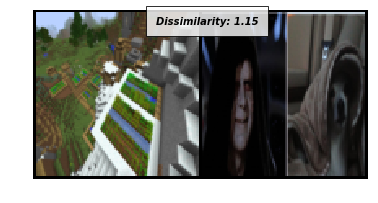

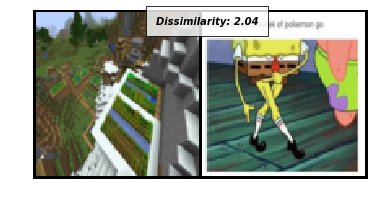

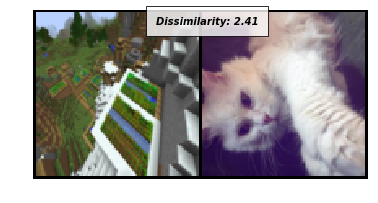

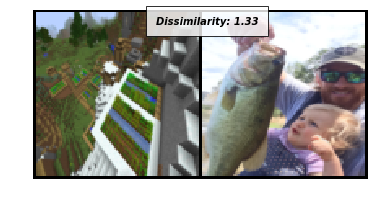

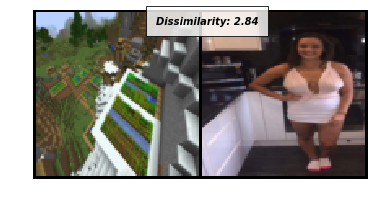

In [14]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(5):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))
    


In [18]:
## create train data, get the mean

In [19]:
class SiameseNetworkDataset_group(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        index = np.random.choice(range(33))
        print (img0_tuple[1])
        img0_tuple = self.imageFolderDataset.imgs[index]
        #we need to make sure approx 50% of images are in the same class
#         should_get_same_class = random.randint(0,1) 
        should_get_same_class = 0
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = np.random.choice(np.array(self.imageFolderDataset.imgs), replace = False)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            index = np.random.choice(range(33))
            img1_tuple = self.imageFolderDataset.imgs[index]
#             img1_tuple = np.random.choice(np.array(self.imageFolderDataset.imgs), replace = False)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, img0_tuple[1], img1_tuple[1] 
        #torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [15]:
class SiameseNetworkDataset_group(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, img0_tuple[1], img1_tuple[1] 
        #torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [16]:
siamese_dataset_group = SiameseNetworkDataset_group(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

train_dataloader = DataLoader(siamese_dataset_group,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


## Visualize 2-D and 3-D clustering of Training Set

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


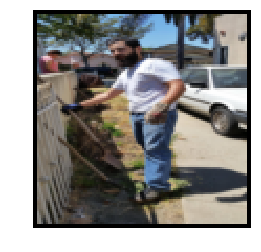

0


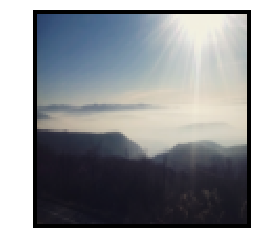

1


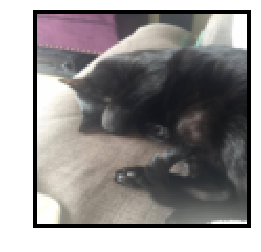

2


/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


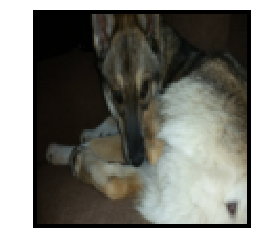

3


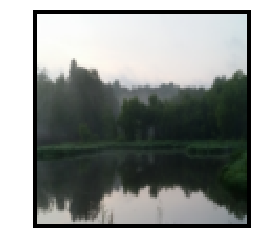

4


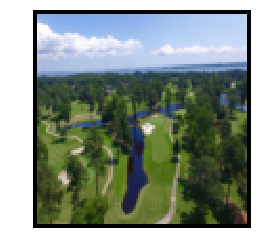

5


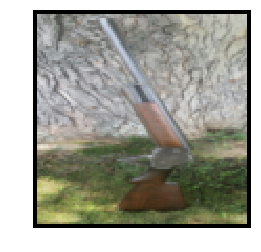

6


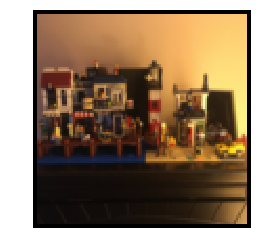

7


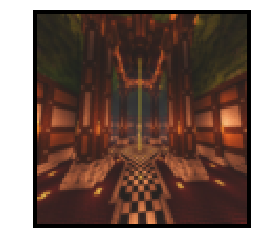

8


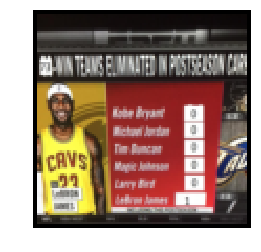

9


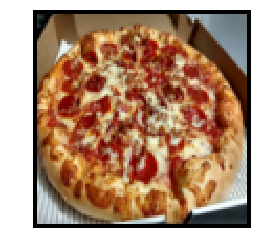

10


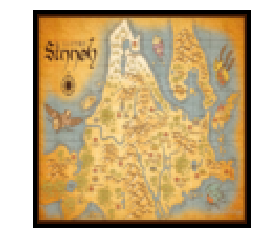

11


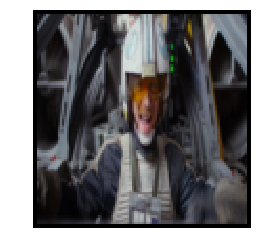

12


/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


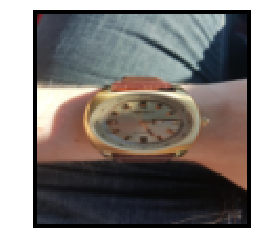

13


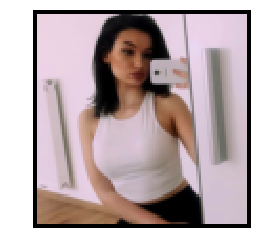

14
{0: 1066, 1: 1325, 2: 5975, 3: 1485, 4: 1564, 5: 1200, 6: 1947, 7: 1622, 8: 1884, 9: 1499, 10: 830, 11: 3237, 12: 1440, 13: 1624, 14: 2281}


In [23]:
#Final k-mean
sub_class = {}
sub_count = {}
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset.imgs: 
    img = Image.open(img_tuple[0])
    img = img.convert("RGB")
    img = transform(img).view(1,3,100,100)
    output1,_ = net(Variable(img).cuda(),Variable(img).cuda())
    label_true = img_tuple[1]
    if label_true not in sub_class.keys():
        sub_class[label_true] = []
        sub_class[label_true].append(output1.cpu().data.numpy().squeeze())
        sub_count[label_true] = 1
        imshow(torchvision.utils.make_grid(img))
        print (img_tuple[1])
    else:
        sub_class[label_true].append(output1.cpu().data.numpy().squeeze())
        sub_count[label_true] += 1
print(sub_count)

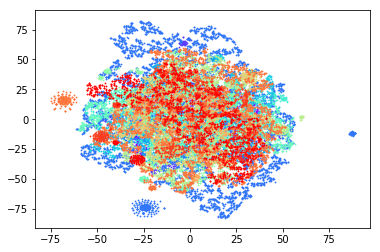

In [29]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 14))
for label, color in zip(sub_class, colors):
    cur = np.array(sub_class[label])
    X_embedded = manifold.TSNE(n_components = 2).fit_transform(cur)
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color, s = 0.6)

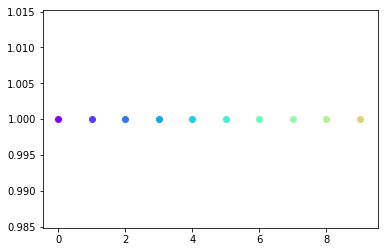

In [30]:
for i, color in zip(range(10),colors):
    plt.scatter(i, 1, c = color)

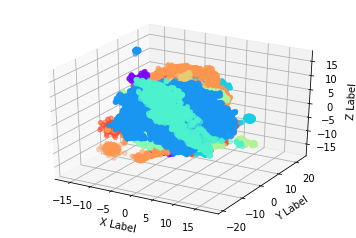

In [26]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = cm.rainbow(np.linspace(0, 1, 11))
for label, color in zip(sub_class, colors):
    cur = np.array(sub_class[label])
    X_embedded = manifold.TSNE(n_components = 3).fit_transform(cur)
    X_mask = X_embedded[:,1] > -500
    count = len(X_mask)
    X_embedded = X_mask.reshape(count,1) * X_embedded
    ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c = color, s = 1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


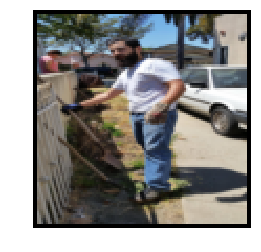

0


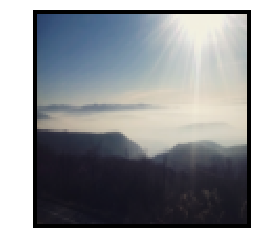

1


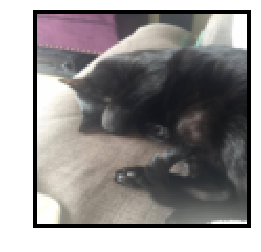

2


/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


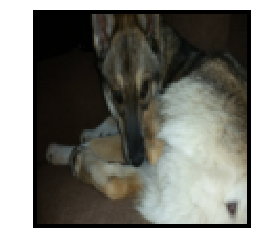

3


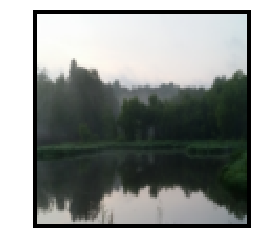

4


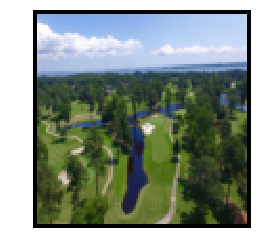

5


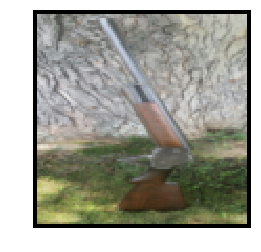

6


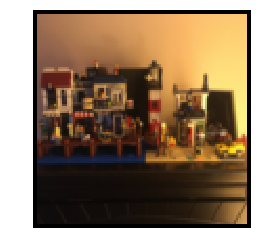

7


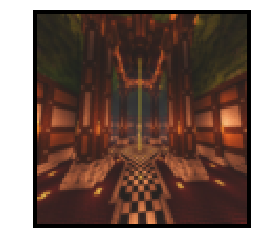

8


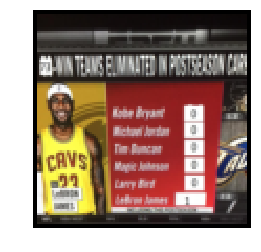

9


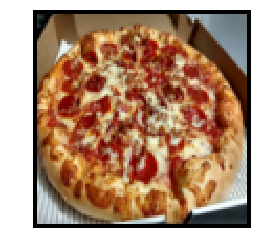

10


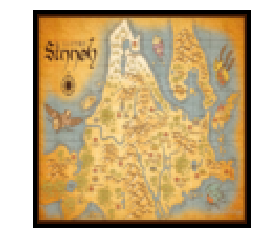

11


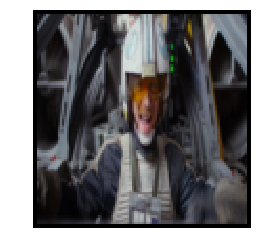

12


/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


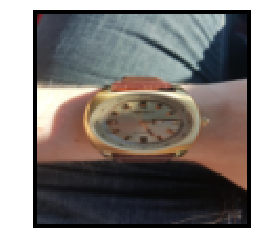

13


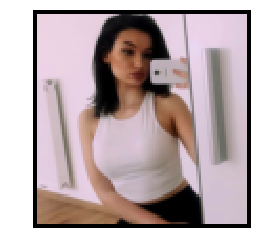

14
{0: 1066, 1: 1325, 2: 5975, 3: 1485, 4: 1564, 5: 1200, 6: 1947, 7: 1622, 8: 1884, 9: 1499, 10: 830, 11: 3237, 12: 1440, 13: 1624, 14: 2281}


In [17]:
#Final k-mean
sub_class = {}
sub_count = {}
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset.imgs: 
    img = Image.open(img_tuple[0])
    img = img.convert("RGB")
    img = transform(img).view(1,3,100,100)
    output1,_ = net(Variable(img).cuda(),Variable(img).cuda())
    label_true = img_tuple[1]
    if label_true not in sub_class.keys():
        sub_class[label_true] = output1.cpu().data.numpy()
        sub_count[label_true] = 1
        imshow(torchvision.utils.make_grid(img))
        print (img_tuple[1])
    else:
        sub_class[label_true] += output1.cpu().data.numpy()
        sub_count[label_true] += 1
print(sub_count)

In [18]:
#Final k-mean
for label in sub_class:
    sub_class[label] = sub_class[label]/sub_count[label]


In [19]:
print(sub_class)

{0: array([[-6.51453257e-01, -1.20527111e-02, -4.50136213e-05,
         8.89594615e-01, -6.06953323e-01,  7.22290993e-01,
        -1.17647685e-02]], dtype=float32), 1: array([[ 0.13419473, -0.00555773, -0.00685514,  0.6497974 ,  1.2047513 ,
        -0.5290905 , -0.01563154]], dtype=float32), 2: array([[ 4.2127216e-01, -6.1118706e-05,  1.7940047e-03,  1.2723826e+00,
         2.2458196e-01,  5.6374389e-01, -6.5322430e-03]], dtype=float32), 3: array([[-0.22484122, -0.01294608,  0.0045663 ,  0.47629407, -0.8003161 ,
         0.73356366, -0.01394442]], dtype=float32), 4: array([[ 0.38047624, -0.01314702,  0.01449451, -0.19467747, -1.116528  ,
         0.722946  , -0.01696163]], dtype=float32), 5: array([[ 0.23848875, -0.01250052,  0.01303988, -0.7062312 , -0.22237325,
        -0.2294905 , -0.02158859]], dtype=float32), 6: array([[ 5.0827688e-01, -3.1382462e-03, -8.5256959e-04,  3.5560453e-01,
         8.8588470e-01, -3.8206670e-01, -1.5117366e-02]], dtype=float32), 7: array([[-5.3100228e-01

In [20]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset_group(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_,_ = next(dataiter)

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [21]:
# dataiter = iter(test_dataloader)
count_true =0 
count = 0
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset_test.imgs:
#     print (img_tuple)
    x1 = Image.open(img_tuple[0])
    x1 = x1.convert("RGB")
    x1 = transform(x1).view(1,3,100,100)
    label_true = img_tuple[1]
    count += 1 
#     _,x1,_,label_true = data
    _,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    pred = {}
    min_score = 10
    pred_class = None
    for label in sub_class:
#         print (label.cpu().data.numpy())
        output1 = sub_class[label]
        output1 = Variable(torch.FloatTensor(output1).cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred[label] = euclidean_distance.cpu().data.numpy()
        if pred[label] < min_score:
            pred_class =  label
            min_score = pred[label]
#     if pred_class == Variable(label_true).data[0]:    
    if pred_class == label_true: 
        count_true+=1
print (count_true/float(count))
    
print (count_true)
print (float(count))

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


0.808
1212
1500.0


## K-Mean

In [35]:
ksub_class = {}
ksub_count = {}
k = 10
from sklearn.cluster import KMeans
for i, data in enumerate(train_dataloader,0):
        img0, img1 , label0, label1 = data
        img0, img1 , label0, label1 = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label0).cuda(), Variable(label1).cuda()
        output1,output2 = net(img0,img1)
        if label0.data[0] not in ksub_class.keys():
            ksub_class[label0.data[0]] = []
            ksub_class[label0.data[0]].append(output1.cpu().data.numpy().squeeze())
            ksub_count[label0.data[0]] = 1
        else:
            ksub_class[label0.data[0]].append(output1.cpu().data.numpy().squeeze())
            ksub_count[label0.data[0]] += 1
            
        if label1.data[0] not in ksub_class.keys():
            ksub_class[label1.data[0]] = []
            ksub_class[label1.data[0]].append( output1.cpu().data.numpy().squeeze())
            ksub_count[label1.data[0]] = 1
        else:
            ksub_class[label1.data[0]].append(output1.cpu().data.numpy().squeeze())
            ksub_count[label1.data[0]] += 1
kmeans={}
for key in ksub_class.keys():
    kmeans[key] = KMeans(n_clusters=k).fit(ksub_class[key])
    

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGB

In [36]:
count = 0
count_true =0 
for img_tuple in folder_dataset_test.imgs:
    x1 = Image.open(img_tuple[0])
    x1 = x1.convert("RGB")
    x1 = transform(x1).view(1,3,100,100)
    label_true = img_tuple[1]
    _,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    pred = {}
    count += 1 
    min_score = 10
    pred_class = None
    for label in ksub_class:
        k_index = kmeans[label].predict(output2.cpu().data.numpy())[0]
        output1 = kmeans[label].cluster_centers_[k_index].reshape((1,7))
        output1 = Variable(torch.FloatTensor(output1).cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred[label] = euclidean_distance.cpu().data.numpy()
        if pred[label] < min_score:
            pred_class =  label
            min_score = pred[label]
#     print (pred_class)
#     print (label_true)
    if pred_class == label_true:       
        count_true+=1
print (count_true/float(count))
    
print (count_true)
print (float(count))
    

0.618
927
1500.0


k = 2 | 0.806

k = 3 | 0.774

k = 10 | 0.618

In [12]:
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files]

In [16]:
import matplotlib.pyplot as plt
directory_path = '/home/shared/CS341/Dataprocessing/finaltest/train'
classes = [d for d in os.listdir('/home/shared/CS341/Dataprocessing/finaltest/train') if os.path.isdir(os.path.join('/home/shared/CS341/Dataprocessing/finaltest/train', d))]
all_images = []
transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
for class_ in classes:
    all_images += (list_pictures(os.path.join('/home/shared/CS341/Dataprocessing/finaltest/train',class_)))
triplets = []
query_image = '/home/shared/CS341/Dataprocessing/finaltest/train/golf/golf-1017557.jpg'         
image1 = Image.open(query_image)
x1 = image1.convert("RGB")
x1 = transform(x1).view(1,3,100,100)
output1 = net.forward_once(Variable(x1).cuda())
distances = {}
for class_ in classes:
        image_names = list_pictures(os.path.join(directory_path,class_))
        for image_name in image_names: 
            image2 = Image.open(image_name)
            x2 = image2.convert("RGB")
            x2 = transform(x2).view(1,3,100,100)
            output2 = net.forward_once(Variable(x2).cuda())

            distance = F.pairwise_distance(output1, output2)
            distances[image_name] = distance.data.cpu().numpy()[0]
count_= 0
import operator
sorted_d = sorted(distances.items(), key=operator.itemgetter(1))

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


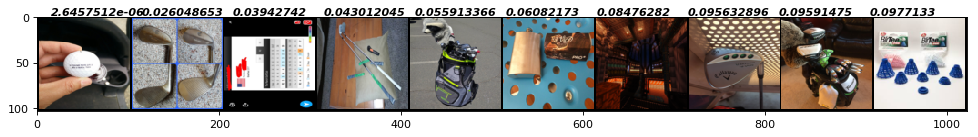

In [17]:
fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
for i in range(10):
    if i == 0:
        im1 = sorted_d[i][0]
        a1 = Image.open(im1)
        a1 = transform(a1).view(1,3,100,100)
    else:
        im = sorted_d[i][0]
        a = Image.open(im)
        a = transform(a).view(1,3,100,100)
        a1 = torch.cat((a1,a), 0)
    plt.text(i*100+15,-2, sorted_d[i][1], style='italic',fontweight='bold')
img = torchvision.utils.make_grid(a1, nrow=10)

img = img.numpy().transpose((1,2,0))
plt.imshow(img)